# compare the different forms of optimization

In [1]:
# Dataset preprocessor to prepare the data for training
import numpy as np
import torch
import pickle
import os
import optuna
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.monocular import MultiDataset
import NTdatasets.conway.cloud_datasets as datasets

import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
from copy import deepcopy

import sys
sys.path.append('./lib')
import runner2 as r
import model as m
import experiment as exp
import plot

from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

%load_ext autoreload
%autoreload 2

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

Invoking __init__.py for NDNT.utils


In [4]:
datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
#fn = 'Jocamo_220727_full_CC_ETCC_nofix_v08'
num_lags=12

In [5]:
t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
115.86169505119324 sec elapsed


In [6]:
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

print(lam_units, 'laminar units', data.robs.shape, 'robs', data.dfs.shape, 'dfs')

167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 128 129 130
 131 132 133 134 135 136 137 138 139 140 141] laminar units torch.Size([167520, 239]) robs torch.Size([167520, 239]) dfs


21 out of 29 units used
Output set to 21 cells


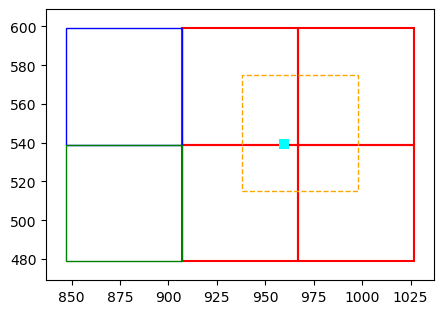

  Stim expansion for shift: [918, 495, 1018, 595]
  Writing lam stim 0: overlap 49, 44
  Writing lam stim 1: overlap 49, 56
  Writing lam stim 2: overlap 51, 56
  Writing lam stim 3: overlap 51, 44
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [7]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
vallam = lam_units[a]
NCv = len(vallam)
print("%d out of %d units used"%(len(vallam), len(lam_units)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_cornerUT = matdat['top_corner'][:, 0]

data.set_cells(vallam)

# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

top_corner_lam = [938, 515]

# Make 60x60 STAs (and GLMs)
Xshift = 0 #8+4 
Yshift = 0 #-10+4
NX = 60

new_tc = np.array([top_corner_lam[0]-Xshift, top_corner_lam[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix

# Dan's method

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

68.5% fixations remaining


In [9]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-8,
    tolerance_grad=1e-8,
    history_size=100,
    batch_size=20,
    max_epochs=3,
    max_iter = 500,
    device = device)

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=5, num_workers=0,
    learning_rate=0.01, early_stopping_patience=10,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches']=6

In [7]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

X2opt = np.zeros([NCv,2])
T2opt = np.zeros([NCv,2])
GLopt = np.zeros([NCv,2])
L1opt = np.zeros([NCv,2])
LLsNULL = np.zeros(NCv)
LLsLR = np.zeros([NCv,4])
LLsQR = np.zeros([NCv,4])

rvals = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
rvalsG = [0.001, 0.1, 1, 10, 100, 1000] # glocal
rvalsL = [0.001, 0.01, 0.1, 1] # L1

# fit Dan models

## drift

In [22]:
dan_drifts = []

for cc in range(NCv):
    drift_filename = 'models/optim/dan_drift_cc'+str(cc)+'.pkl'

    # continue if the file already exists
    if os.path.isfile(drift_filename):
        # load the model and continue
        print('loading model', cc)
        with open(drift_filename, 'rb') as f:
            dan_drifts.append(pickle.load(f))
            LLsNULL[cc] = dan_drifts[cc].LLs
        continue
    
    data.set_cells([vallam[cc]])
    
    # fit drift network
    drift_iter = NDN.NDN(
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_iter.block_sample=True
    drift_iter.networks[0].xstim_n = 'Xdrift'
    drift_iter.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LLsNULL[cc] = drift_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
    
    dan_drifts.append(Model(drift_iter, LLsNULL[cc], cc))
    
    with open(drift_filename, 'wb') as f:
        pickle.dump(dan_drifts[cc], f)

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12
loading model 13
loading model 14
loading model 15
loading model 16
loading model 17
loading model 18
loading model 19
loading model 20


## glm

In [23]:
dan_glms = []

for cc in range(NCv):
    glm_filename = 'models/optim/dan_glm_cc'+str(cc)+'.pkl'
    
    # continue if the file already exists
    if os.path.isfile(glm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(glm_filename, 'rb') as f:
            dan_glms.append(pickle.load(f))
            LLsLR[cc,:] = dan_glms[cc].LLs
        continue

    data.set_cells([vallam[cc]])

    best_model = None
    LLs = np.zeros(len(rvals)) + float('inf')
    for rr in range(len(rvals)):
        stim_net['layer_list'][0]['reg_vals']['d2xt'] = rvals[rr]
        glm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_iter.block_sample=True
        glm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            dan_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0])
        glm_iter.networks[1].layers[0].set_parameters(val=False)
        glm_iter.networks[2].layers[0].set_parameters(val=False,name='weight')

        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm0 = np.argmin(LLs)
    LLsLR[cc,0] = LLs[bm0]
    X2opt[cc, 0] = rvals[bm0]
    print( "GLM %3d:  d2xt-R%d   LLs ="%(cc, bm0), LLsNULL[cc]-LLsLR[cc,0] )

    LLs = np.zeros(len(rvalsG))+LLsLR[cc,0]
    for rr in range(len(rvalsG)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]

        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm1 = np.argmin(LLs)
    if LLs[bm1] < LLsLR[cc,0]:
        LLsLR[cc,1] = LLs[bm1]
    else:
        LLsLR[cc,1] = LLsLR[cc,0]

    GLopt[cc,0] = rvalsG[bm1]
    #glms[cc] = deepcopy(best_model)
    print( "GLM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bm1, LLsNULL[cc]-LLsLR[cc,0], LLsNULL[cc]-LLsLR[cc,1]) )

    # L1 optimization
    LLs = np.zeros(len(rvalsL))+LLsLR[cc,1]
    for rr in range(len(rvalsL)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['l1'] = rvalsL[rr]
        #if bm2>1:
        #glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[bm2-1]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm2 = np.argmin(LLs)
    if LLs[bm2] < LLsLR[cc,1]:
        LLsLR[cc,2] = LLs[bm2]
    else:
        LLsLR[cc,2] = LLsLR[cc,1]

    L1opt[cc,0] = rvalsL[bm2]

    dan_glms.append(Model(deepcopy(best_model), LLsNULL[cc]-LLsLR[cc,2], cc))

    # save model
    with open(glm_filename, 'wb') as f:
        pickle.dump(dan_glms[cc], f)

    print( "GLM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bm2, LLsNULL[cc]-LLsLR[cc,1], LLsNULL[cc]-LLsLR[cc,2]) )

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12
loading model 13
loading model 14
loading model 15
loading model 16
loading model 17
loading model 18
loading model 19
loading model 20


## gqm

In [20]:
dan_gqms = []
for cc in range(NCv):
    gqm_filename = 'models/optim/dan_gqm_cc'+str(cc)+'.pkl'

    # continue if the file already exists
    if os.path.isfile(gqm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(gqm_filename, 'rb') as f:
            dan_gqms.append(pickle.load(f))
            LLsQR[cc,0] = dan_gqms[cc].LLs
        continue

    data.set_cells([vallam[cc]])

    best_model = None

    # now fit GQM
    LLs = np.zeros(len(rvals))+ 1000 #+LLsR[cc,0]
    LLsQR[cc,0] = LLsLR[cc,2]

    # get the best reg_vals for the GLM
    best_reg_vals = dan_glms[cc].ndn_model.networks[0].layers[0].reg.vals
    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    gqm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
    gqm_iter.networks[0].layers[0] = deepcopy(dan_glms[cc].ndn_model.networks[0].layers[0])
    gqm_iter.block_sample=True
    gqm_iter.networks[3].layers[0].set_parameters(val=False,name='weight')
    gqm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
        dan_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0])
    gqm_iter.networks[1].layers[0].set_parameters(val=False)

    for rr in range(len(rvalsG)):
        gqm_iter.networks[2].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi

    bmq1 = np.argmin(LLs)
    LLsQR[cc,1] = LLs[bmq1]
    GLopt[cc,1] = rvals[bmq1]
    print( "GQM %3d:  Gloc-R%d   LL = %9.6f ->%9.6f"%(cc, bmq1, LLsNULL[cc]-LLsLR[cc,2], LLsNULL[cc]-LLsQR[cc,1]) )

    LLs = np.zeros(len(rvals))+LLsQR[cc,1]
    for rr in range(len(rvals)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['d2xt'] = rvals[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi

    bmq2 = np.argmin(LLs)
    if LLs[bmq2] < LLsQR[cc,1]:
        LLsQR[cc,2] = LLs[bmq2]
    else:
        LLsQR[cc,2] = LLsQR[cc,1]

    X2opt[cc,1] = rvals[bmq2]
    print( "GQM %3d:  d2xt-R%d   LL = %9.6f ->%9.6f"%(cc, bmq2, LLsNULL[cc]-LLsQR[cc,1], LLsNULL[cc]-LLsQR[cc,2]) )

    LLs = np.zeros(len(rvalsL))+LLsQR[cc,2]
    for rr in range(len(rvalsL)):
        gqm_iter = deepcopy(best_model)
        gqm_iter.networks[2].layers[0].reg.vals['l1'] = rvalsL[rr]
        gqm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = gqm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(gqm_iter)
        LLs[rr] = LLi

    bmq3 = np.argmin(LLs)
    if LLs[bmq3] < LLsQR[cc,2]:
        LLsQR[cc,3] = LLs[bmq3]
    else:
        LLsQR[cc,3] = LLsQR[cc,2]

    L1opt[cc,1] = rvalsL[bmq3]

    dan_gqms.append(Model(deepcopy(best_model), LLsNULL[cc]-LLsQR[cc,3], cc))

    # save the model
    # gqm_filename
    with open(glm_filename, 'wb') as f:
        pickle.dump(dan_gqms[cc], f)

    print( "GQM %3d:    L1-R%d   LL = %9.6f ->%9.6f"%(cc, bmq3, LLsNULL[cc]-LLsQR[cc,2], LLsNULL[cc]-LLsQR[cc,3]) )

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12
loading model 13
loading model 14
loading model 15
loading model 16
loading model 17
loading model 18
Output set to 1 cells
input dims [4, 1, 1, 1]
GQM  19:  Gloc-R4   LL =  3.461979 -> 0.036854
GQM  19:  d2xt-R5   LL =  0.036854 -> 0.037023
GQM  19:    L1-R3   LL =  0.037023 -> 0.037102
Output set to 1 cells
input dims [4, 1, 1, 1]
GQM  20:  Gloc-R4   LL =  4.618642 ->-0.000003
GQM  20:  d2xt-R5   LL = -0.000003 -> 0.000526
GQM  20:    L1-R2   LL =  0.000526 -> 0.000535


# fit Matt models

## drift

In [8]:
import optuna

matt_drifts = []

for cc in range(NCv):
    drift_filename = 'models/optim/matt_drift_cc'+str(cc)+'.pkl'
    
    # # continue if the file already exists
    if os.path.isfile(drift_filename):
        # load the model and continue
        print('loading model', cc)
        with open(drift_filename, 'rb') as f:
            matt_drifts.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])

    matt_drifts_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=trial.suggest_float('tolerance_change', 1e-10, 1e-4, log=True),
            tolerance_grad=trial.suggest_float('tolerance_grad', 1e-10, 1e-4, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        # drift network
        drift_pars1 = NDNLayer.layer_dict(
            input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
        drift_pars1['reg_vals'] = {'d2t': trial.suggest_float('d2t', 0.0, 1.0), 'bcs':{'d2t':0} }
        # for stand-alone drift model
        drift_pars1N = deepcopy(drift_pars1)
        drift_pars1N['NLtype'] = 'softplus'
        drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

        drift_ndn = NDN.NDN(
            layer_list = [drift_pars1N], loss_type='poisson')
        drift_ndn.block_sample=True
        drift_ndn.networks[0].xstim_n = 'Xdrift'

        drift_ndn.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
        LL = drift_ndn.eval_models(data[data.val_blks], null_adjusted=False)[0]

        drift_model = Model(drift_ndn, LL, trial)
        matt_drifts_temp.append(drift_model)

        return LL

    study = optuna.create_study(direction='minimize')

    # enqueue initial parameters
    study.enqueue_trial(
        {'d2t': Dreg,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})

    study.optimize(objective, n_trials=10)

    matt_drifts.append(matt_drifts_temp[study.best_trial.number])

    with open(drift_filename, 'wb') as f:
        pickle.dump(matt_drifts[cc], f)

    print(study.best_trial.number, study.best_params)

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12
loading model 13
loading model 14
loading model 15
loading model 16
loading model 17
loading model 18
loading model 19
loading model 20


## glm

In [9]:
matt_glms = []
for cc in range(NCv):
    glm_filename = 'models/optim/matt_glm_cc'+str(cc)+'.pkl'
    
    drift_weights = matt_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0]
    
    # # continue if the file already exists
    if os.path.isfile(glm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(glm_filename, 'rb') as f:
            matt_glms.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])
    
    LLsNULL_cc = matt_drifts[cc].LLs

    matt_glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    matt_glm.block_sample=True
    matt_glm.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
    matt_glm.networks[1].layers[0].set_parameters(val=False)
    matt_glm.networks[2].layers[0].set_parameters(val=False,name='weight')

    matt_glms_temp = []
    
    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=1e-10*trial.suggest_int('tolerance_change', 10, 1e6, log=True),
            tolerance_grad=1e-10*trial.suggest_int('tolerance_grad', 10, 1e6, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        matt_glm.networks[0].layers[0].reg.vals['d2x'] = 1e-5*trial.suggest_int('d2x', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['d2t'] = 1e-5*trial.suggest_int('d2t', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['d2xt'] = 1e-5*trial.suggest_int('d2xt', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['l1'] = 1e-5*trial.suggest_int('l1', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['glocalx'] = 1e-5*trial.suggest_int('glocalx', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['edge_t'] = 1e-5*trial.suggest_int('edge_t', 10, 1e10, log=True)
    
        matt_glm.fit( data, force_dict_training=True, trial=trial, **lbfgs_pars)
        LL = matt_glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
    
        glm_model = Model(matt_glm, LLsNULL_cc-LL, trial)
        matt_glms_temp.append(glm_model)
        
        return LLsNULL_cc-LL
    
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
    
    # enqueue initial parameters
    # study.enqueue_trial(
    #     {'d2t': 1,
    #      'd2x': 20,
    #      'l1': 0.1,
    #      'glocalx': 10.0,
    #      'edge_t': 10,
    #      'tolerance_change': 1e-8,
    #      'tolerance_grad': 1e-8})
    
    study.optimize(objective, n_trials=15)
    
    matt_glms.append(matt_glms_temp[study.best_trial.number])
    
    with open(glm_filename, 'wb') as f:
        matt_glms[cc].trial = study
        pickle.dump(matt_glms[cc], f)
    
    print(study.best_trial.number, study.best_params)

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12


[I 2023-07-04 08:39:03,704] A new study created in memory with name: no-name-f9c0584b-9024-42cc-a3ae-b87fd858e695


Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 64.09137082099915 sec elapsed


[I 2023-07-04 08:40:08,561] Trial 0 finished with value: -0.00014495849609375 and parameters: {'tolerance_change': 9499, 'tolerance_grad': 152514, 'd2x': 23, 'd2t': 323622, 'd2xt': 22, 'l1': 487433570, 'glocalx': 79966275, 'edge_t': 84862}. Best is trial 0 with value: -0.00014495849609375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.226454973220825 sec elapsed


[I 2023-07-04 08:41:09,650] Trial 1 finished with value: -0.0002932548522949219 and parameters: {'tolerance_change': 2955, 'tolerance_grad': 115635, 'd2x': 60446834, 'd2t': 364156165, 'd2xt': 6211054, 'l1': 388980500, 'glocalx': 2670632, 'edge_t': 161636}. Best is trial 0 with value: -0.00014495849609375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4176316261291504 sec elapsed


[I 2023-07-04 08:41:12,816] Trial 2 finished with value: 0.0003299713134765625 and parameters: {'tolerance_change': 16908, 'tolerance_grad': 13444, 'd2x': 2245, 'd2t': 9017, 'd2xt': 45, 'l1': 16, 'glocalx': 6207333925, 'edge_t': 32565916}. Best is trial 2 with value: 0.0003299713134765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.1572904586792 sec elapsed


[I 2023-07-04 08:42:13,739] Trial 3 finished with value: -0.35408878326416016 and parameters: {'tolerance_change': 2815, 'tolerance_grad': 28, 'd2x': 4738858, 'd2t': 248, 'd2xt': 1294737, 'l1': 8954457, 'glocalx': 13, 'edge_t': 30978013}. Best is trial 2 with value: 0.0003299713134765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.770880699157715 sec elapsed


[I 2023-07-04 08:42:19,274] Trial 4 finished with value: -0.00019359588623046875 and parameters: {'tolerance_change': 7873, 'tolerance_grad': 12, 'd2x': 1715, 'd2t': 45930, 'd2xt': 3972718186, 'l1': 14, 'glocalx': 8768438, 'edge_t': 30}. Best is trial 2 with value: 0.0003299713134765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.072965145111084 sec elapsed


[I 2023-07-04 08:42:22,093] Trial 5 finished with value: 0.0006442070007324219 and parameters: {'tolerance_change': 499, 'tolerance_grad': 4019, 'd2x': 7868127, 'd2t': 12, 'd2xt': 100819304, 'l1': 2469, 'glocalx': 262028314, 'edge_t': 61936}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.8225908279418945 sec elapsed


[I 2023-07-04 08:42:24,678] Trial 6 finished with value: 0.000484466552734375 and parameters: {'tolerance_change': 44100, 'tolerance_grad': 60, 'd2x': 2752360025, 'd2t': 193493, 'd2xt': 1421407799, 'l1': 102804, 'glocalx': 255869706, 'edge_t': 729}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4923772811889648 sec elapsed


[I 2023-07-04 08:42:26,919] Trial 7 finished with value: 0.00041484832763671875 and parameters: {'tolerance_change': 13852, 'tolerance_grad': 736658, 'd2x': 2934468, 'd2t': 197, 'd2xt': 184704288, 'l1': 443, 'glocalx': 1250853894, 'edge_t': 259}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.600130319595337 sec elapsed


[I 2023-07-04 08:42:29,266] Trial 8 finished with value: 0.00026798248291015625 and parameters: {'tolerance_change': 136832, 'tolerance_grad': 1582, 'd2x': 16703, 'd2t': 216732, 'd2xt': 4726367920, 'l1': 239752, 'glocalx': 35894, 'edge_t': 6594529}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.3841018676757812 sec elapsed


[I 2023-07-04 08:42:31,399] Trial 9 finished with value: 2.384185791015625e-05 and parameters: {'tolerance_change': 187670, 'tolerance_grad': 85650, 'd2x': 32968, 'd2t': 8426, 'd2xt': 3456538, 'l1': 11032559, 'glocalx': 473, 'edge_t': 44}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.810109376907349 sec elapsed


[I 2023-07-04 08:42:42,996] Trial 10 finished with value: -0.01054239273071289 and parameters: {'tolerance_change': 133, 'tolerance_grad': 958, 'd2x': 5405004996, 'd2t': 30, 'd2xt': 52062, 'l1': 3118, 'glocalx': 157068, 'edge_t': 2190960812}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.127685546875 sec elapsed


[I 2023-07-04 08:42:48,913] Trial 11 finished with value: 0.0006413459777832031 and parameters: {'tolerance_change': 132, 'tolerance_grad': 198, 'd2x': 4083569788, 'd2t': 12470271, 'd2xt': 217503576, 'l1': 29352, 'glocalx': 144009168, 'edge_t': 3392}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.5289292335510254 sec elapsed


[I 2023-07-04 08:42:52,236] Trial 12 finished with value: 0.0003085136413574219 and parameters: {'tolerance_change': 61, 'tolerance_grad': 205, 'd2x': 117605084, 'd2t': 22207996, 'd2xt': 108077449, 'l1': 7179, 'glocalx': 5933439774, 'edge_t': 5281}. Best is trial 5 with value: 0.0006442070007324219.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.51550555229187 sec elapsed


[I 2023-07-04 08:42:55,542] Trial 13 finished with value: 0.0008287429809570312 and parameters: {'tolerance_change': 342, 'tolerance_grad': 318, 'd2x': 405084405, 'd2t': 10, 'd2xt': 58031515, 'l1': 19034, 'glocalx': 65235192, 'edge_t': 10508}. Best is trial 13 with value: 0.0008287429809570312.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.1793575286865234 sec elapsed


[I 2023-07-04 08:42:58,509] Trial 14 finished with value: 0.0006089210510253906 and parameters: {'tolerance_change': 443, 'tolerance_grad': 3215, 'd2x': 109185638, 'd2t': 10, 'd2xt': 15052080, 'l1': 572, 'glocalx': 9857939, 'edge_t': 21435}. Best is trial 13 with value: 0.0008287429809570312.
[I 2023-07-04 08:42:58,520] A new study created in memory with name: no-name-2f515f53-e735-4672-9d22-3ba92a8936c9


13 {'tolerance_change': 342, 'tolerance_grad': 318, 'd2x': 405084405, 'd2t': 10, 'd2xt': 58031515, 'l1': 19034, 'glocalx': 65235192, 'edge_t': 10508}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.1754467487335205 sec elapsed


[I 2023-07-04 08:43:02,443] Trial 0 finished with value: 0.01528477668762207 and parameters: {'tolerance_change': 82843, 'tolerance_grad': 316429, 'd2x': 734, 'd2t': 1376, 'd2xt': 29, 'l1': 561187, 'glocalx': 97893, 'edge_t': 10660288}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.3872578144073486 sec elapsed


[I 2023-07-04 08:43:06,582] Trial 1 finished with value: 0.01024484634399414 and parameters: {'tolerance_change': 35744, 'tolerance_grad': 136, 'd2x': 265, 'd2t': 2856501, 'd2xt': 1625129, 'l1': 24, 'glocalx': 926730209, 'edge_t': 52}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.12688708305359 sec elapsed


[I 2023-07-04 08:44:07,455] Trial 2 finished with value: -0.0007755756378173828 and parameters: {'tolerance_change': 370, 'tolerance_grad': 63347, 'd2x': 10227429, 'd2t': 5409316, 'd2xt': 31, 'l1': 1388088227, 'glocalx': 364485, 'edge_t': 576847334}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.062437772750854 sec elapsed


[I 2023-07-04 08:45:08,265] Trial 3 finished with value: 7.867813110351562e-06 and parameters: {'tolerance_change': 49188, 'tolerance_grad': 3510, 'd2x': 52181, 'd2t': 14355, 'd2xt': 31747, 'l1': 526306452, 'glocalx': 1108237414, 'edge_t': 1209938}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.76019859313965 sec elapsed


[I 2023-07-04 08:46:09,791] Trial 4 finished with value: -0.00041222572326660156 and parameters: {'tolerance_change': 4692, 'tolerance_grad': 217897, 'd2x': 87026364, 'd2t': 158974010, 'd2xt': 238209375, 'l1': 250323073, 'glocalx': 257600, 'edge_t': 66}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.429635763168335 sec elapsed


[I 2023-07-04 08:46:12,978] Trial 5 finished with value: 0.003147125244140625 and parameters: {'tolerance_change': 87601, 'tolerance_grad': 119, 'd2x': 1077353996, 'd2t': 9244508, 'd2xt': 5947870337, 'l1': 52, 'glocalx': 43067806, 'edge_t': 3035678}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.64444398880005 sec elapsed


[I 2023-07-04 08:47:14,371] Trial 6 finished with value: -3.0517578125e-05 and parameters: {'tolerance_change': 84, 'tolerance_grad': 52, 'd2x': 829062121, 'd2t': 280086826, 'd2xt': 59937, 'l1': 291430952, 'glocalx': 36509939, 'edge_t': 2854387762}. Best is trial 0 with value: 0.01528477668762207.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.75365161895752 sec elapsed


[I 2023-07-04 08:47:24,875] Trial 7 finished with value: 0.01978898048400879 and parameters: {'tolerance_change': 770, 'tolerance_grad': 94, 'd2x': 770, 'd2t': 1783433, 'd2xt': 11022019, 'l1': 692078, 'glocalx': 6755925, 'edge_t': 287636}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.6023473739624 sec elapsed


[I 2023-07-04 08:48:26,225] Trial 8 finished with value: -3.600120544433594e-05 and parameters: {'tolerance_change': 10, 'tolerance_grad': 461092, 'd2x': 2131782104, 'd2t': 790, 'd2xt': 10, 'l1': 922864049, 'glocalx': 870067395, 'edge_t': 227}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.61812686920166 sec elapsed


[I 2023-07-04 08:49:27,598] Trial 9 finished with value: 1.52587890625e-05 and parameters: {'tolerance_change': 568, 'tolerance_grad': 3662, 'd2x': 94, 'd2t': 5436, 'd2xt': 2846679045, 'l1': 2248050590, 'glocalx': 6248089872, 'edge_t': 559906}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.452979564666748 sec elapsed


[I 2023-07-04 08:49:32,845] Trial 10 finished with value: 0.0010104179382324219 and parameters: {'tolerance_change': 5868, 'tolerance_grad': 13, 'd2x': 71134, 'd2t': 10, 'd2xt': 15387098, 'l1': 377005, 'glocalx': 108, 'edge_t': 8469}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.1599438190460205 sec elapsed


[I 2023-07-04 08:49:36,778] Trial 11 finished with value: 0.01351022720336914 and parameters: {'tolerance_change': 609482, 'tolerance_grad': 958645, 'd2x': 1457, 'd2t': 7771824696, 'd2xt': 2427, 'l1': 414481, 'glocalx': 63551, 'edge_t': 30624075}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2763566970825195 sec elapsed


[I 2023-07-04 08:49:38,828] Trial 12 finished with value: 0.013742685317993164 and parameters: {'tolerance_change': 601641, 'tolerance_grad': 20569, 'd2x': 4519, 'd2t': 133386, 'd2xt': 4477909, 'l1': 3968406, 'glocalx': 6129, 'edge_t': 35271}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6036880016326904 sec elapsed


[I 2023-07-04 08:49:42,205] Trial 13 finished with value: 0.015418291091918945 and parameters: {'tolerance_change': 1481, 'tolerance_grad': 996, 'd2x': 30, 'd2t': 117, 'd2xt': 2154, 'l1': 15071, 'glocalx': 4564777, 'edge_t': 38316381}. Best is trial 7 with value: 0.01978898048400879.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9492876529693604 sec elapsed


[I 2023-07-04 08:49:44,945] Trial 14 finished with value: 0.015888690948486328 and parameters: {'tolerance_change': 1372, 'tolerance_grad': 608, 'd2x': 14, 'd2t': 10, 'd2xt': 2551, 'l1': 6492, 'glocalx': 8435031, 'edge_t': 181493355}. Best is trial 7 with value: 0.01978898048400879.
[I 2023-07-04 08:49:44,954] A new study created in memory with name: no-name-86bc62ab-5704-4cb8-b6cd-c07e27f91991


7 {'tolerance_change': 770, 'tolerance_grad': 94, 'd2x': 770, 'd2t': 1783433, 'd2xt': 11022019, 'l1': 692078, 'glocalx': 6755925, 'edge_t': 287636}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.52865552902222 sec elapsed


[I 2023-07-04 08:50:46,230] Trial 0 finished with value: -0.00037479400634765625 and parameters: {'tolerance_change': 46997, 'tolerance_grad': 120565, 'd2x': 25080642, 'd2t': 109, 'd2xt': 22, 'l1': 75507691, 'glocalx': 485869, 'edge_t': 9768367}. Best is trial 0 with value: -0.00037479400634765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.360450267791748 sec elapsed


[I 2023-07-04 08:50:51,340] Trial 1 finished with value: 0.001102447509765625 and parameters: {'tolerance_change': 437, 'tolerance_grad': 245060, 'd2x': 2959466071, 'd2t': 766343643, 'd2xt': 60027816, 'l1': 687254, 'glocalx': 80165, 'edge_t': 1410597392}. Best is trial 1 with value: 0.001102447509765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.0028760433197 sec elapsed


[I 2023-07-04 08:51:52,092] Trial 2 finished with value: -0.01669454574584961 and parameters: {'tolerance_change': 38, 'tolerance_grad': 20824, 'd2x': 49633, 'd2t': 804445, 'd2xt': 7739497046, 'l1': 1077487043, 'glocalx': 586176, 'edge_t': 274695}. Best is trial 1 with value: 0.001102447509765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.192481994628906 sec elapsed


[I 2023-07-04 08:52:53,050] Trial 3 finished with value: -0.1731557846069336 and parameters: {'tolerance_change': 37171, 'tolerance_grad': 57662, 'd2x': 10002432, 'd2t': 88258, 'd2xt': 63909054, 'l1': 2095609, 'glocalx': 3572, 'edge_t': 24116107}. Best is trial 1 with value: 0.001102447509765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.062806606292725 sec elapsed


[I 2023-07-04 08:53:53,863] Trial 4 finished with value: -0.42005205154418945 and parameters: {'tolerance_change': 116439, 'tolerance_grad': 13130, 'd2x': 444, 'd2t': 174, 'd2xt': 70660, 'l1': 777218280, 'glocalx': 424644, 'edge_t': 10670}. Best is trial 1 with value: 0.001102447509765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.160717248916626 sec elapsed


[I 2023-07-04 08:54:54,773] Trial 5 finished with value: -136.54217529296875 and parameters: {'tolerance_change': 10230, 'tolerance_grad': 11955, 'd2x': 68810280, 'd2t': 82, 'd2xt': 453731044, 'l1': 308118490, 'glocalx': 77, 'edge_t': 3204515447}. Best is trial 1 with value: 0.001102447509765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.055133819580078 sec elapsed


[I 2023-07-04 08:55:02,594] Trial 6 finished with value: 0.0014214515686035156 and parameters: {'tolerance_change': 36987, 'tolerance_grad': 78, 'd2x': 3204957314, 'd2t': 95, 'd2xt': 5005317826, 'l1': 61, 'glocalx': 8091811305, 'edge_t': 37051}. Best is trial 6 with value: 0.0014214515686035156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6293294429779053 sec elapsed


[I 2023-07-04 08:55:05,972] Trial 7 finished with value: -0.009795188903808594 and parameters: {'tolerance_change': 27, 'tolerance_grad': 235606, 'd2x': 215322832, 'd2t': 26546, 'd2xt': 25720, 'l1': 97, 'glocalx': 47674, 'edge_t': 11568}. Best is trial 6 with value: 0.0014214515686035156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 59.962299823760986 sec elapsed


[I 2023-07-04 08:56:06,681] Trial 8 finished with value: 0.003464221954345703 and parameters: {'tolerance_change': 214, 'tolerance_grad': 487, 'd2x': 625, 'd2t': 441, 'd2xt': 16770, 'l1': 51268044, 'glocalx': 11213, 'edge_t': 24131312}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.16200256347656 sec elapsed


[I 2023-07-04 08:57:07,588] Trial 9 finished with value: -0.04587268829345703 and parameters: {'tolerance_change': 31, 'tolerance_grad': 37, 'd2x': 342, 'd2t': 6859916, 'd2xt': 742332, 'l1': 2198325271, 'glocalx': 70198, 'edge_t': 20}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.51554274559021 sec elapsed


[I 2023-07-04 08:57:15,890] Trial 10 finished with value: -0.25469398498535156 and parameters: {'tolerance_change': 1371, 'tolerance_grad': 1084, 'd2x': 15, 'd2t': 4807, 'd2xt': 596, 'l1': 25446, 'glocalx': 34, 'edge_t': 31693809}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.762863874435425 sec elapsed


[I 2023-07-04 08:57:20,438] Trial 11 finished with value: 0.002719879150390625 and parameters: {'tolerance_change': 772209, 'tolerance_grad': 164, 'd2x': 6557504842, 'd2t': 14, 'd2xt': 1474987, 'l1': 20, 'glocalx': 2928571625, 'edge_t': 326470}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4056265354156494 sec elapsed


[I 2023-07-04 08:57:22,634] Trial 12 finished with value: 0.002323150634765625 and parameters: {'tolerance_change': 458955, 'tolerance_grad': 691, 'd2x': 155087, 'd2t': 10, 'd2xt': 1056738, 'l1': 3604, 'glocalx': 9548071064, 'edge_t': 1722970}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2746524810791016 sec elapsed


[I 2023-07-04 08:57:24,682] Trial 13 finished with value: 0.002312183380126953 and parameters: {'tolerance_change': 915633, 'tolerance_grad': 10, 'd2x': 1242502, 'd2t': 4616, 'd2xt': 10103, 'l1': 20843568, 'glocalx': 138417516, 'edge_t': 123214229}. Best is trial 8 with value: 0.003464221954345703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.6949968338012695 sec elapsed


[I 2023-07-04 08:57:29,153] Trial 14 finished with value: 0.008100509643554688 and parameters: {'tolerance_change': 261, 'tolerance_grad': 299, 'd2x': 18080, 'd2t': 735, 'd2xt': 301906, 'l1': 12, 'glocalx': 36582638, 'edge_t': 495204}. Best is trial 14 with value: 0.008100509643554688.
[I 2023-07-04 08:57:29,171] A new study created in memory with name: no-name-85b66ac8-1d13-4388-9c85-1d03bc3b5285


14 {'tolerance_change': 261, 'tolerance_grad': 299, 'd2x': 18080, 'd2t': 735, 'd2xt': 301906, 'l1': 12, 'glocalx': 36582638, 'edge_t': 495204}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 39.3524227142334 sec elapsed


[I 2023-07-04 08:58:09,273] Trial 0 finished with value: 0.0016303062438964844 and parameters: {'tolerance_change': 34, 'tolerance_grad': 15, 'd2x': 611724, 'd2t': 13952, 'd2xt': 29029, 'l1': 1276688, 'glocalx': 4091172576, 'edge_t': 92387648}. Best is trial 0 with value: 0.0016303062438964844.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9909780025482178 sec elapsed


[I 2023-07-04 08:58:12,015] Trial 1 finished with value: -0.06003570556640625 and parameters: {'tolerance_change': 228423, 'tolerance_grad': 57, 'd2x': 8654357, 'd2t': 619, 'd2xt': 5564, 'l1': 553, 'glocalx': 15265, 'edge_t': 1081}. Best is trial 0 with value: 0.0016303062438964844.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.2685775756835938 sec elapsed


[I 2023-07-04 08:58:16,033] Trial 2 finished with value: 0.004900932312011719 and parameters: {'tolerance_change': 12314, 'tolerance_grad': 41060, 'd2x': 1059357908, 'd2t': 148699, 'd2xt': 191, 'l1': 159060, 'glocalx': 6639819, 'edge_t': 154993}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 59.95532512664795 sec elapsed


[I 2023-07-04 08:59:16,736] Trial 3 finished with value: -0.0035305023193359375 and parameters: {'tolerance_change': 1937, 'tolerance_grad': 712435, 'd2x': 762642, 'd2t': 149056, 'd2xt': 5780023, 'l1': 4195098, 'glocalx': 4484, 'edge_t': 3302}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.09520959854126 sec elapsed


[I 2023-07-04 09:00:17,580] Trial 4 finished with value: -0.01554250717163086 and parameters: {'tolerance_change': 37030, 'tolerance_grad': 128, 'd2x': 12727569, 'd2t': 3222, 'd2xt': 4858, 'l1': 742729, 'glocalx': 17196, 'edge_t': 52224}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.02274203300476 sec elapsed


[I 2023-07-04 09:01:18,352] Trial 5 finished with value: -2.037151336669922 and parameters: {'tolerance_change': 157, 'tolerance_grad': 1181, 'd2x': 258, 'd2t': 122334, 'd2xt': 3244206, 'l1': 977260233, 'glocalx': 222, 'edge_t': 912134}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.125566244125366 sec elapsed


[I 2023-07-04 09:02:19,230] Trial 6 finished with value: -0.0009093284606933594 and parameters: {'tolerance_change': 22, 'tolerance_grad': 405, 'd2x': 447140, 'd2t': 1760143615, 'd2xt': 974446, 'l1': 1059437577, 'glocalx': 497609, 'edge_t': 29639990}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.410287141799927 sec elapsed


[I 2023-07-04 09:02:24,389] Trial 7 finished with value: 0.0014619827270507812 and parameters: {'tolerance_change': 14, 'tolerance_grad': 12, 'd2x': 1499, 'd2t': 4030, 'd2xt': 138, 'l1': 2301, 'glocalx': 4723509997, 'edge_t': 1038053008}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.841390132904053 sec elapsed


[I 2023-07-04 09:02:29,977] Trial 8 finished with value: 0.0037207603454589844 and parameters: {'tolerance_change': 420, 'tolerance_grad': 239404, 'd2x': 2773, 'd2t': 30026, 'd2xt': 2448, 'l1': 514874, 'glocalx': 50008604, 'edge_t': 60420}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 59.92587089538574 sec elapsed


[I 2023-07-04 09:03:30,653] Trial 9 finished with value: 1.430511474609375e-06 and parameters: {'tolerance_change': 21643, 'tolerance_grad': 164480, 'd2x': 69687, 'd2t': 566, 'd2xt': 309090, 'l1': 1169851673, 'glocalx': 3914662471, 'edge_t': 109782727}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.879389047622681 sec elapsed


[I 2023-07-04 09:03:37,329] Trial 10 finished with value: 0.0019330978393554688 and parameters: {'tolerance_change': 6976, 'tolerance_grad': 17302, 'd2x': 9372651749, 'd2t': 18, 'd2xt': 13, 'l1': 14, 'glocalx': 3183399, 'edge_t': 12}. Best is trial 2 with value: 0.004900932312011719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.719484567642212 sec elapsed


[I 2023-07-04 09:03:40,820] Trial 11 finished with value: 0.004961967468261719 and parameters: {'tolerance_change': 813, 'tolerance_grad': 13884, 'd2x': 14, 'd2t': 13456357, 'd2xt': 583481986, 'l1': 43239, 'glocalx': 24017115, 'edge_t': 938487}. Best is trial 11 with value: 0.004961967468261719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.742300271987915 sec elapsed


[I 2023-07-04 09:03:43,352] Trial 12 finished with value: 0.004946708679199219 and parameters: {'tolerance_change': 1187, 'tolerance_grad': 10270, 'd2x': 10, 'd2t': 3516488, 'd2xt': 770591301, 'l1': 18163, 'glocalx': 19061001, 'edge_t': 1712969}. Best is trial 11 with value: 0.004961967468261719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4892871379852295 sec elapsed


[I 2023-07-04 09:03:46,615] Trial 13 finished with value: 0.0038299560546875 and parameters: {'tolerance_change': 1037, 'tolerance_grad': 5360, 'd2x': 12, 'd2t': 38777671, 'd2xt': 1172550181, 'l1': 9135, 'glocalx': 70899725, 'edge_t': 8775089}. Best is trial 11 with value: 0.004961967468261719.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.288798809051514 sec elapsed


[I 2023-07-04 09:03:51,677] Trial 14 finished with value: 0.002399921417236328 and parameters: {'tolerance_change': 190, 'tolerance_grad': 3885, 'd2x': 12, 'd2t': 9373969, 'd2xt': 1799990912, 'l1': 28429, 'glocalx': 81083468, 'edge_t': 7830823178}. Best is trial 11 with value: 0.004961967468261719.
[I 2023-07-04 09:03:51,697] A new study created in memory with name: no-name-a61cda87-869d-48e4-8672-bf97a081e554


11 {'tolerance_change': 813, 'tolerance_grad': 13884, 'd2x': 14, 'd2t': 13456357, 'd2xt': 583481986, 'l1': 43239, 'glocalx': 24017115, 'edge_t': 938487}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.0522148609161377 sec elapsed


[I 2023-07-04 09:03:55,498] Trial 0 finished with value: -0.023406267166137695 and parameters: {'tolerance_change': 120491, 'tolerance_grad': 44256, 'd2x': 88, 'd2t': 40721492, 'd2xt': 265161, 'l1': 69677, 'glocalx': 35, 'edge_t': 314285}. Best is trial 0 with value: -0.023406267166137695.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.434077024459839 sec elapsed


[I 2023-07-04 09:04:04,683] Trial 1 finished with value: 0.011294126510620117 and parameters: {'tolerance_change': 5234, 'tolerance_grad': 8426, 'd2x': 56717, 'd2t': 2612199, 'd2xt': 162284, 'l1': 700912, 'glocalx': 4192534824, 'edge_t': 33588292}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.776914834976196 sec elapsed


[I 2023-07-04 09:04:11,209] Trial 2 finished with value: 0.00734710693359375 and parameters: {'tolerance_change': 2167, 'tolerance_grad': 5662, 'd2x': 409706480, 'd2t': 3625388692, 'd2xt': 20420123, 'l1': 59308, 'glocalx': 7897, 'edge_t': 2283}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.75925803184509 sec elapsed


[I 2023-07-04 09:05:12,734] Trial 3 finished with value: -0.029950380325317383 and parameters: {'tolerance_change': 13851, 'tolerance_grad': 14, 'd2x': 12, 'd2t': 130719, 'd2xt': 24, 'l1': 115621351, 'glocalx': 13860, 'edge_t': 41}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.184248924255371 sec elapsed


[I 2023-07-04 09:05:16,684] Trial 4 finished with value: -0.03276371955871582 and parameters: {'tolerance_change': 3292, 'tolerance_grad': 28, 'd2x': 46, 'd2t': 6270, 'd2xt': 5807, 'l1': 55541, 'glocalx': 3318, 'edge_t': 496}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.75436854362488 sec elapsed


[I 2023-07-04 09:06:18,206] Trial 5 finished with value: -0.0022878646850585938 and parameters: {'tolerance_change': 382, 'tolerance_grad': 353, 'd2x': 9843831, 'd2t': 293258, 'd2xt': 968781, 'l1': 2592322567, 'glocalx': 1420908343, 'edge_t': 82}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.3320753574371338 sec elapsed


[I 2023-07-04 09:06:20,300] Trial 6 finished with value: -0.0021932125091552734 and parameters: {'tolerance_change': 733800, 'tolerance_grad': 76, 'd2x': 812168, 'd2t': 268, 'd2xt': 27, 'l1': 68718874, 'glocalx': 141, 'edge_t': 23504}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.281231641769409 sec elapsed


[I 2023-07-04 09:06:25,332] Trial 7 finished with value: 0.0037953853607177734 and parameters: {'tolerance_change': 19212, 'tolerance_grad': 84, 'd2x': 172227012, 'd2t': 43, 'd2xt': 61192738, 'l1': 1680073, 'glocalx': 2431802254, 'edge_t': 3856}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.391461133956909 sec elapsed


[I 2023-07-04 09:06:30,492] Trial 8 finished with value: 0.008373737335205078 and parameters: {'tolerance_change': 15, 'tolerance_grad': 21, 'd2x': 1342, 'd2t': 5304, 'd2xt': 3591486948, 'l1': 168, 'glocalx': 6671941, 'edge_t': 8542610}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.1864852905273438 sec elapsed


[I 2023-07-04 09:06:33,448] Trial 9 finished with value: -0.06403517723083496 and parameters: {'tolerance_change': 6725, 'tolerance_grad': 196839, 'd2x': 4044995, 'd2t': 102, 'd2xt': 215, 'l1': 110, 'glocalx': 1671, 'edge_t': 8787}. Best is trial 1 with value: 0.011294126510620117.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.577463388442993 sec elapsed


[I 2023-07-04 09:06:43,800] Trial 10 finished with value: 0.043094635009765625 and parameters: {'tolerance_change': 239, 'tolerance_grad': 2407, 'd2x': 89979, 'd2t': 16032899, 'd2xt': 7342, 'l1': 1410, 'glocalx': 10884331, 'edge_t': 8616657860}. Best is trial 10 with value: 0.043094635009765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.233356237411499 sec elapsed


[I 2023-07-04 09:06:49,825] Trial 11 finished with value: 0.036981821060180664 and parameters: {'tolerance_change': 254, 'tolerance_grad': 3553, 'd2x': 26484, 'd2t': 24184161, 'd2xt': 9024, 'l1': 1777, 'glocalx': 37021955, 'edge_t': 8408152010}. Best is trial 10 with value: 0.043094635009765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.357805967330933 sec elapsed


[I 2023-07-04 09:06:56,957] Trial 12 finished with value: 0.03963637351989746 and parameters: {'tolerance_change': 182, 'tolerance_grad': 1114, 'd2x': 24860, 'd2t': 58586585, 'd2xt': 3752, 'l1': 823, 'glocalx': 7585590, 'edge_t': 8522602908}. Best is trial 10 with value: 0.043094635009765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.562671184539795 sec elapsed


[I 2023-07-04 09:07:06,311] Trial 13 finished with value: 0.017760038375854492 and parameters: {'tolerance_change': 39, 'tolerance_grad': 857, 'd2x': 6841, 'd2t': 1035446023, 'd2xt': 1546, 'l1': 11, 'glocalx': 608101, 'edge_t': 9861073985}. Best is trial 10 with value: 0.043094635009765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.468545436859131 sec elapsed


[I 2023-07-04 09:07:11,554] Trial 14 finished with value: 0.030620574951171875 and parameters: {'tolerance_change': 201, 'tolerance_grad': 928, 'd2x': 223315, 'd2t': 106682206, 'd2xt': 735, 'l1': 1763, 'glocalx': 48679051, 'edge_t': 524703659}. Best is trial 10 with value: 0.043094635009765625.
[I 2023-07-04 09:07:11,578] A new study created in memory with name: no-name-c2762182-9d2f-4398-9fb7-3898b08a2d22


10 {'tolerance_change': 239, 'tolerance_grad': 2407, 'd2x': 89979, 'd2t': 16032899, 'd2xt': 7342, 'l1': 1410, 'glocalx': 10884331, 'edge_t': 8616657860}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.69004797935486 sec elapsed


[I 2023-07-04 09:08:13,038] Trial 0 finished with value: -0.012749671936035156 and parameters: {'tolerance_change': 10411, 'tolerance_grad': 18, 'd2x': 6438520, 'd2t': 2255553, 'd2xt': 26308533, 'l1': 3168226033, 'glocalx': 8053, 'edge_t': 264307}. Best is trial 0 with value: -0.012749671936035156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.471746206283569 sec elapsed


[I 2023-07-04 09:08:20,257] Trial 1 finished with value: -0.4664645195007324 and parameters: {'tolerance_change': 1787, 'tolerance_grad': 570, 'd2x': 3670, 'd2t': 352987, 'd2xt': 73334, 'l1': 159, 'glocalx': 57, 'edge_t': 466429034}. Best is trial 0 with value: -0.012749671936035156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.535127639770508 sec elapsed


[I 2023-07-04 09:08:24,560] Trial 2 finished with value: 0.0003190040588378906 and parameters: {'tolerance_change': 216802, 'tolerance_grad': 1631, 'd2x': 341, 'd2t': 752347, 'd2xt': 55541, 'l1': 2465069, 'glocalx': 262263791, 'edge_t': 201109}. Best is trial 2 with value: 0.0003190040588378906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.322273015975952 sec elapsed


[I 2023-07-04 09:08:30,651] Trial 3 finished with value: -0.03883028030395508 and parameters: {'tolerance_change': 4246, 'tolerance_grad': 298, 'd2x': 3440744, 'd2t': 226265415, 'd2xt': 11502281, 'l1': 12208, 'glocalx': 60, 'edge_t': 812897974}. Best is trial 2 with value: 0.0003190040588378906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.9703989028930664 sec elapsed


[I 2023-07-04 09:08:34,388] Trial 4 finished with value: -0.4308481216430664 and parameters: {'tolerance_change': 38, 'tolerance_grad': 19, 'd2x': 23723335, 'd2t': 1222, 'd2xt': 455, 'l1': 115, 'glocalx': 12, 'edge_t': 34}. Best is trial 2 with value: 0.0003190040588378906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.584237813949585 sec elapsed


[I 2023-07-04 09:09:35,722] Trial 5 finished with value: -140.5134735107422 and parameters: {'tolerance_change': 1231, 'tolerance_grad': 372575, 'd2x': 26574489, 'd2t': 47, 'd2xt': 131, 'l1': 221155290, 'glocalx': 120, 'edge_t': 27}. Best is trial 2 with value: 0.0003190040588378906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 51.063234090805054 sec elapsed


[I 2023-07-04 09:10:27,535] Trial 6 finished with value: 1.4781951904296875e-05 and parameters: {'tolerance_change': 576985, 'tolerance_grad': 103, 'd2x': 24, 'd2t': 162, 'd2xt': 61392183, 'l1': 10006823, 'glocalx': 192680931, 'edge_t': 2313920559}. Best is trial 2 with value: 0.0003190040588378906.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.113462924957275 sec elapsed


[I 2023-07-04 09:10:33,415] Trial 7 finished with value: 0.0005087852478027344 and parameters: {'tolerance_change': 4320, 'tolerance_grad': 54824, 'd2x': 287804, 'd2t': 6834099957, 'd2xt': 4170285959, 'l1': 222, 'glocalx': 543148, 'edge_t': 41902476}. Best is trial 7 with value: 0.0005087852478027344.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.080031394958496 sec elapsed


[I 2023-07-04 09:10:36,244] Trial 8 finished with value: -0.2909846305847168 and parameters: {'tolerance_change': 22617, 'tolerance_grad': 38, 'd2x': 7210785, 'd2t': 204882, 'd2xt': 13, 'l1': 13, 'glocalx': 576, 'edge_t': 342687}. Best is trial 7 with value: 0.0005087852478027344.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.4013068675994873 sec elapsed


[I 2023-07-04 09:10:40,412] Trial 9 finished with value: 0.0013337135314941406 and parameters: {'tolerance_change': 1603, 'tolerance_grad': 44, 'd2x': 19640920, 'd2t': 231, 'd2xt': 69, 'l1': 8826, 'glocalx': 22842417, 'edge_t': 276103}. Best is trial 9 with value: 0.0013337135314941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.102877378463745 sec elapsed


[I 2023-07-04 09:10:46,305] Trial 10 finished with value: 0.0004467964172363281 and parameters: {'tolerance_change': 74, 'tolerance_grad': 3451, 'd2x': 8590946552, 'd2t': 2435, 'd2xt': 1258, 'l1': 46497, 'glocalx': 6054211701, 'edge_t': 3226}. Best is trial 9 with value: 0.0013337135314941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.447988271713257 sec elapsed


[I 2023-07-04 09:10:53,529] Trial 11 finished with value: 0.0006346702575683594 and parameters: {'tolerance_change': 379, 'tolerance_grad': 19016, 'd2x': 60658, 'd2t': 4206512437, 'd2xt': 3989878735, 'l1': 3567, 'glocalx': 931185, 'edge_t': 12565433}. Best is trial 9 with value: 0.0013337135314941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.873449802398682 sec elapsed


[I 2023-07-04 09:10:59,195] Trial 12 finished with value: 0.00048828125 and parameters: {'tolerance_change': 372, 'tolerance_grad': 9522, 'd2x': 17820, 'd2t': 17, 'd2xt': 7812701176, 'l1': 21127, 'glocalx': 1105739, 'edge_t': 12227764}. Best is trial 9 with value: 0.0013337135314941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.52034068107605 sec elapsed


[I 2023-07-04 09:11:07,507] Trial 13 finished with value: -0.0016016960144042969 and parameters: {'tolerance_change': 10, 'tolerance_grad': 13697, 'd2x': 42173, 'd2t': 5754977679, 'd2xt': 7193, 'l1': 6349, 'glocalx': 4899509, 'edge_t': 6737942}. Best is trial 9 with value: 0.0013337135314941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 27.774994373321533 sec elapsed


[I 2023-07-04 09:11:36,057] Trial 14 finished with value: 0.00125885009765625 and parameters: {'tolerance_change': 329, 'tolerance_grad': 195, 'd2x': 262808, 'd2t': 49996192, 'd2xt': 555581, 'l1': 376211, 'glocalx': 12595, 'edge_t': 39619}. Best is trial 9 with value: 0.0013337135314941406.
[I 2023-07-04 09:11:36,112] A new study created in memory with name: no-name-b862ce14-c1cb-4b08-8105-3a3c59493373


9 {'tolerance_change': 1603, 'tolerance_grad': 44, 'd2x': 19640920, 'd2t': 231, 'd2xt': 69, 'l1': 8826, 'glocalx': 22842417, 'edge_t': 276103}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.7257452011108398 sec elapsed


[I 2023-07-04 09:11:38,588] Trial 0 finished with value: 0.010353803634643555 and parameters: {'tolerance_change': 656690, 'tolerance_grad': 431, 'd2x': 23, 'd2t': 511, 'd2xt': 131851548, 'l1': 186, 'glocalx': 1737, 'edge_t': 7639134769}. Best is trial 0 with value: 0.010353803634643555.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.299956798553467 sec elapsed


[I 2023-07-04 09:11:47,639] Trial 1 finished with value: 0.019685029983520508 and parameters: {'tolerance_change': 516, 'tolerance_grad': 262, 'd2x': 6860213604, 'd2t': 387956, 'd2xt': 23792, 'l1': 274125, 'glocalx': 53, 'edge_t': 4370}. Best is trial 1 with value: 0.019685029983520508.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 15.967059135437012 sec elapsed


[I 2023-07-04 09:12:04,358] Trial 2 finished with value: 0.012421369552612305 and parameters: {'tolerance_change': 165, 'tolerance_grad': 1838, 'd2x': 7997509177, 'd2t': 12, 'd2xt': 735164619, 'l1': 752206, 'glocalx': 432, 'edge_t': 2613905313}. Best is trial 1 with value: 0.019685029983520508.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.327965259552002 sec elapsed


[I 2023-07-04 09:12:09,434] Trial 3 finished with value: 0.02986741065979004 and parameters: {'tolerance_change': 221, 'tolerance_grad': 268230, 'd2x': 244492551, 'd2t': 36219, 'd2xt': 494, 'l1': 93931, 'glocalx': 2203210, 'edge_t': 942219}. Best is trial 3 with value: 0.02986741065979004.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0607101917266846 sec elapsed


[I 2023-07-04 09:12:12,243] Trial 4 finished with value: 0.02550649642944336 and parameters: {'tolerance_change': 23921, 'tolerance_grad': 5057, 'd2x': 118126550, 'd2t': 2006288, 'd2xt': 132270786, 'l1': 14, 'glocalx': 8557559, 'edge_t': 118540}. Best is trial 3 with value: 0.02986741065979004.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0467731952667236 sec elapsed


[I 2023-07-04 09:12:15,049] Trial 5 finished with value: 0.030144929885864258 and parameters: {'tolerance_change': 47955, 'tolerance_grad': 141, 'd2x': 7095252, 'd2t': 94614213, 'd2xt': 5430075, 'l1': 947, 'glocalx': 466571, 'edge_t': 334347}. Best is trial 5 with value: 0.030144929885864258.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8271539211273193 sec elapsed


[I 2023-07-04 09:12:18,640] Trial 6 finished with value: 0.03146696090698242 and parameters: {'tolerance_change': 289, 'tolerance_grad': 18, 'd2x': 2437907, 'd2t': 1952308, 'd2xt': 789, 'l1': 53803, 'glocalx': 452806, 'edge_t': 7369}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.4162888526916504 sec elapsed


[I 2023-07-04 09:12:22,805] Trial 7 finished with value: 0.007308006286621094 and parameters: {'tolerance_change': 151759, 'tolerance_grad': 300381, 'd2x': 1733201143, 'd2t': 3877892, 'd2xt': 6145928328, 'l1': 789, 'glocalx': 416514, 'edge_t': 1074799709}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.649497032165527 sec elapsed


[I 2023-07-04 09:12:29,208] Trial 8 finished with value: 0.026060104370117188 and parameters: {'tolerance_change': 13, 'tolerance_grad': 19224, 'd2x': 536, 'd2t': 1077449, 'd2xt': 27891095, 'l1': 42376, 'glocalx': 22856677, 'edge_t': 82248407}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.1910645961761475 sec elapsed


[I 2023-07-04 09:12:32,168] Trial 9 finished with value: 0.021355390548706055 and parameters: {'tolerance_change': 945903, 'tolerance_grad': 457655, 'd2x': 4680860045, 'd2t': 3095, 'd2xt': 17663, 'l1': 35, 'glocalx': 12, 'edge_t': 10}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.38198494911194 sec elapsed


[I 2023-07-04 09:13:33,370] Trial 10 finished with value: 4.2438507080078125e-05 and parameters: {'tolerance_change': 5148, 'tolerance_grad': 10, 'd2x': 139109, 'd2t': 8452823486, 'd2xt': 23, 'l1': 401113133, 'glocalx': 3554636378, 'edge_t': 257}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.1474368572235107 sec elapsed


[I 2023-07-04 09:13:36,332] Trial 11 finished with value: 0.019696712493896484 and parameters: {'tolerance_change': 50136, 'tolerance_grad': 14, 'd2x': 3545388, 'd2t': 112493328, 'd2xt': 2379575, 'l1': 3020, 'glocalx': 26959, 'edge_t': 166046}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.283778190612793 sec elapsed


[I 2023-07-04 09:13:39,409] Trial 12 finished with value: 0.024235010147094727 and parameters: {'tolerance_change': 4142, 'tolerance_grad': 72, 'd2x': 1377926, 'd2t': 105392981, 'd2xt': 705009, 'l1': 5317, 'glocalx': 46229, 'edge_t': 5343402}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 61.01217842102051 sec elapsed


[I 2023-07-04 09:14:41,209] Trial 13 finished with value: -0.11763691902160645 and parameters: {'tolerance_change': 13423, 'tolerance_grad': 38, 'd2x': 72067, 'd2t': 54162681, 'd2xt': 46413, 'l1': 4401865, 'glocalx': 21616, 'edge_t': 9837}. Best is trial 6 with value: 0.03146696090698242.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.928785562515259 sec elapsed


[I 2023-07-04 09:14:46,938] Trial 14 finished with value: 0.013044357299804688 and parameters: {'tolerance_change': 1289, 'tolerance_grad': 105, 'd2x': 14097478, 'd2t': 3449914679, 'd2xt': 1072, 'l1': 10624, 'glocalx': 56426681, 'edge_t': 4793934}. Best is trial 6 with value: 0.03146696090698242.
[I 2023-07-04 09:14:46,960] A new study created in memory with name: no-name-42653c08-2f2a-41ff-a9f6-f80e0b76a251


6 {'tolerance_change': 289, 'tolerance_grad': 18, 'd2x': 2437907, 'd2t': 1952308, 'd2xt': 789, 'l1': 53803, 'glocalx': 452806, 'edge_t': 7369}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.797023057937622 sec elapsed


[I 2023-07-04 09:14:53,535] Trial 0 finished with value: -0.002276897430419922 and parameters: {'tolerance_change': 8972, 'tolerance_grad': 658117, 'd2x': 6831238599, 'd2t': 252, 'd2xt': 351083484, 'l1': 18375, 'glocalx': 1243386, 'edge_t': 1710}. Best is trial 0 with value: -0.002276897430419922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.756083250045776 sec elapsed


[I 2023-07-04 09:15:55,073] Trial 1 finished with value: -0.6511516571044922 and parameters: {'tolerance_change': 6955, 'tolerance_grad': 2028, 'd2x': 1548840387, 'd2t': 6272590, 'd2xt': 2980, 'l1': 31006900, 'glocalx': 41610, 'edge_t': 77}. Best is trial 0 with value: -0.002276897430419922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.802381277084351 sec elapsed


[I 2023-07-04 09:16:00,636] Trial 2 finished with value: -0.005736827850341797 and parameters: {'tolerance_change': 5886, 'tolerance_grad': 290, 'd2x': 945, 'd2t': 1427000234, 'd2xt': 3584899743, 'l1': 1578304, 'glocalx': 429, 'edge_t': 42}. Best is trial 0 with value: -0.002276897430419922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.72985339164734 sec elapsed


[I 2023-07-04 09:17:02,132] Trial 3 finished with value: -0.0008831024169921875 and parameters: {'tolerance_change': 4613, 'tolerance_grad': 2835, 'd2x': 1650417719, 'd2t': 1773967025, 'd2xt': 7337, 'l1': 8581786532, 'glocalx': 425755, 'edge_t': 109817}. Best is trial 3 with value: -0.0008831024169921875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.013554573059082 sec elapsed


[I 2023-07-04 09:17:06,916] Trial 4 finished with value: -0.002716541290283203 and parameters: {'tolerance_change': 850, 'tolerance_grad': 355, 'd2x': 256, 'd2t': 349183, 'd2xt': 866398295, 'l1': 14, 'glocalx': 3867283, 'edge_t': 9983679}. Best is trial 3 with value: -0.0008831024169921875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.75450110435486 sec elapsed


[I 2023-07-04 09:18:08,454] Trial 5 finished with value: -0.013800621032714844 and parameters: {'tolerance_change': 44125, 'tolerance_grad': 287, 'd2x': 6082, 'd2t': 69551544, 'd2xt': 11323, 'l1': 75074151, 'glocalx': 312, 'edge_t': 84459}. Best is trial 3 with value: -0.0008831024169921875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 15.546897649765015 sec elapsed


[I 2023-07-04 09:18:24,784] Trial 6 finished with value: -0.03551197052001953 and parameters: {'tolerance_change': 17, 'tolerance_grad': 18, 'd2x': 26, 'd2t': 5012510062, 'd2xt': 530, 'l1': 172, 'glocalx': 16, 'edge_t': 144}. Best is trial 3 with value: -0.0008831024169921875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.936980724334717 sec elapsed


[I 2023-07-04 09:18:31,503] Trial 7 finished with value: -0.0025320053100585938 and parameters: {'tolerance_change': 17, 'tolerance_grad': 104775, 'd2x': 7892123, 'd2t': 2140494310, 'd2xt': 319550908, 'l1': 468, 'glocalx': 5626225, 'edge_t': 31}. Best is trial 3 with value: -0.0008831024169921875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.666123151779175 sec elapsed


[I 2023-07-04 09:18:35,954] Trial 8 finished with value: -0.0006742477416992188 and parameters: {'tolerance_change': 24, 'tolerance_grad': 456125, 'd2x': 4355813510, 'd2t': 1155, 'd2xt': 2406, 'l1': 11039, 'glocalx': 95108843, 'edge_t': 367355}. Best is trial 8 with value: -0.0006742477416992188.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4316675662994385 sec elapsed


[I 2023-07-04 09:18:38,176] Trial 9 finished with value: 0.0003795623779296875 and parameters: {'tolerance_change': 773698, 'tolerance_grad': 24, 'd2x': 635, 'd2t': 773072, 'd2xt': 8278, 'l1': 10235, 'glocalx': 1335179, 'edge_t': 9263152337}. Best is trial 9 with value: 0.0003795623779296875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6471431255340576 sec elapsed


[I 2023-07-04 09:18:40,637] Trial 10 finished with value: 0.0004143714904785156 and parameters: {'tolerance_change': 698018, 'tolerance_grad': 11, 'd2x': 49667, 'd2t': 16739, 'd2xt': 13, 'l1': 75007, 'glocalx': 9404032970, 'edge_t': 1416970490}. Best is trial 10 with value: 0.0004143714904785156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.1940147876739502 sec elapsed


[I 2023-07-04 09:18:42,624] Trial 11 finished with value: 0.0004143714904785156 and parameters: {'tolerance_change': 980403, 'tolerance_grad': 17, 'd2x': 62997, 'd2t': 14731, 'd2xt': 49, 'l1': 38376, 'glocalx': 2278873033, 'edge_t': 2948209573}. Best is trial 10 with value: 0.0004143714904785156.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.298255443572998 sec elapsed


[I 2023-07-04 09:18:44,719] Trial 12 finished with value: 0.0006208419799804688 and parameters: {'tolerance_change': 946749, 'tolerance_grad': 16, 'd2x': 66943, 'd2t': 7821, 'd2xt': 14, 'l1': 220844, 'glocalx': 3772167249, 'edge_t': 3159076971}. Best is trial 12 with value: 0.0006208419799804688.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.537137746810913 sec elapsed


[I 2023-07-04 09:18:47,069] Trial 13 finished with value: 0.0005021095275878906 and parameters: {'tolerance_change': 147017, 'tolerance_grad': 67, 'd2x': 477250, 'd2t': 10847, 'd2xt': 14, 'l1': 618927, 'glocalx': 9649775248, 'edge_t': 226126902}. Best is trial 12 with value: 0.0006208419799804688.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.4246909618377686 sec elapsed


[I 2023-07-04 09:18:49,306] Trial 14 finished with value: 0.0004940032958984375 and parameters: {'tolerance_change': 153749, 'tolerance_grad': 79, 'd2x': 2069850, 'd2t': 26, 'd2xt': 14, 'l1': 1034486, 'glocalx': 492677620, 'edge_t': 167423382}. Best is trial 12 with value: 0.0006208419799804688.


12 {'tolerance_change': 946749, 'tolerance_grad': 16, 'd2x': 66943, 'd2t': 7821, 'd2xt': 14, 'l1': 220844, 'glocalx': 3772167249, 'edge_t': 3159076971}


## gqm

In [20]:
matt_gqms = []
for cc in range(NCv):
    gqm_filename = 'models/optim/matt_gqm_cc'+str(cc)+'.pkl'

    drift_weights = matt_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0]

    # # continue if the file already exists
    if os.path.isfile(gqm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(gqm_filename, 'rb') as f:
            matt_gqms.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])

    LLsNULL_cc = matt_drifts[cc].LLs

    # get the best reg_vals for the GLM
    best_reg_vals = matt_glms[cc].ndn_model.networks[0].layers[0].reg.vals
    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)
    matt_gqm = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
    matt_gqm.networks[0].layers[0] = deepcopy(matt_glms[cc].ndn_model.networks[0].layers[0])
    matt_gqm.block_sample=True
    matt_gqm.networks[3].layers[0].set_parameters(val=False,name='weight')
    matt_gqm.networks[1].layers[0].weight.data[:,0] = deepcopy(
        matt_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0])
    matt_gqm.networks[1].layers[0].set_parameters(val=False)

    matt_gqms_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=1e-10*trial.suggest_int('tolerance_change', 10, 1e6, log=True),
            tolerance_grad=1e-10*trial.suggest_int('tolerance_grad', 10, 1e6, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        matt_gqm.networks[0].layers[0].reg.vals['d2x'] = 1e-5*trial.suggest_int('d2x', 10, 1e10, log=True)
        matt_gqm.networks[0].layers[0].reg.vals['d2t'] = 1e-5*trial.suggest_int('d2t', 10, 1e10, log=True)
        matt_gqm.networks[0].layers[0].reg.vals['d2xt'] = 1e-5*trial.suggest_int('d2xt', 10, 1e10, log=True)
        matt_gqm.networks[0].layers[0].reg.vals['l1'] = 1e-5*trial.suggest_int('l1', 10, 1e10, log=True)
        matt_gqm.networks[0].layers[0].reg.vals['glocalx'] = 1e-5*trial.suggest_int('glocalx', 10, 1e10, log=True)
        matt_gqm.networks[0].layers[0].reg.vals['edge_t'] = 1e-5*trial.suggest_int('edge_t', 10, 1e10, log=True)

        matt_gqm.fit( data, force_dict_training=True, **lbfgs_pars)
        LL = matt_gqm.eval_models(data[data.val_blks], null_adjusted=False)[0]

        gqm_model = Model(matt_gqm, LLsNULL_cc-LL, trial)
        matt_gqms_temp.append(gqm_model)

        return LLsNULL_cc-LL

    study = optuna.create_study(direction='minimize')

    study.optimize(objective, n_trials=20)

    matt_gqms.append(matt_gqms_temp[study.best_trial.number])

    with open(gqm_filename, 'wb') as f:
        matt_gqms[cc].trial = study
        pickle.dump(matt_gqms[cc], f)

    print(study.best_trial.number, study.best_params)

[I 2023-07-04 00:04:24,264] A new study created in memory with name: no-name-466ebe0c-9d63-400b-b4b4-58f88a746672


Output set to 1 cells
input dims [4, 1, 1, 1]

GPU Available: True, GPU Used: True


[W 2023-07-04 00:04:25,244] Trial 0 failed with parameters: {'tolerance_change': 4.098209022705205e-05, 'tolerance_grad': 1.933736083508257e-10, 'd2x': 183, 'd2t': 605448, 'd2xt': 51906380, 'l1': 1194071, 'glocalx': 9526994, 'edge_t': 4149278322} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 1.80 GiB (GPU 1; 23.70 GiB total capacity; 11.11 GiB already allocated; 1.52 GiB free; 11.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2315697/1765875056.py", line 49, in objective
    matt_gqm.fit( data, force_dict_training=True, **lbfgs_pars)
  File 

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.80 GiB (GPU 1; 23.70 GiB total capacity; 11.11 GiB already allocated; 1.52 GiB free; 11.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# plot GLM

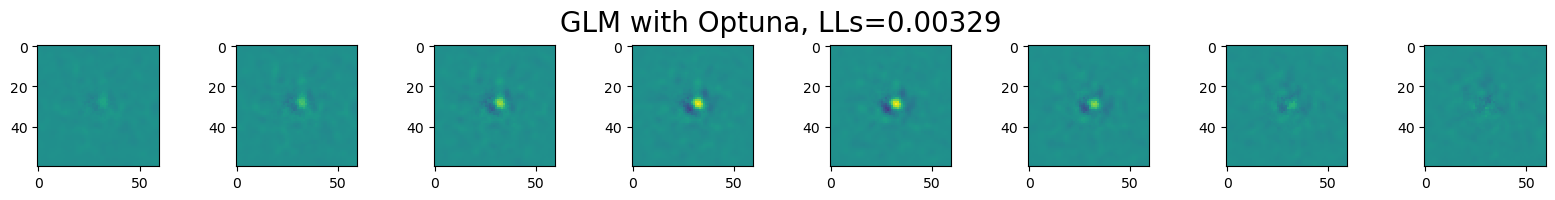

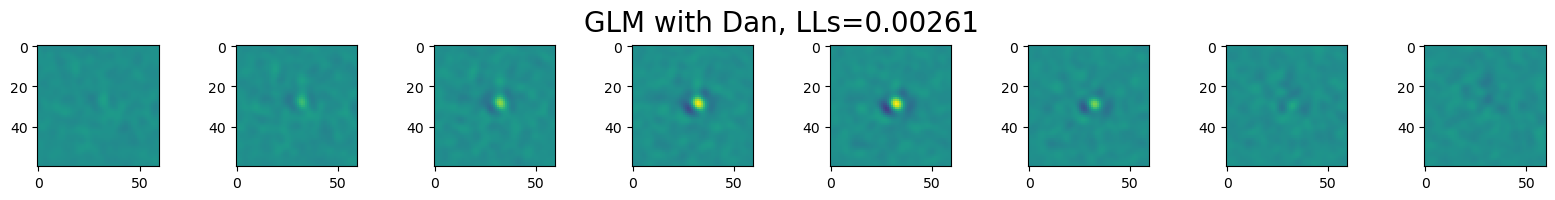

In [32]:
w_lin = matt_glms[0].ndn_model.networks[0].layers[0].get_weights()
utils.subplot_setup(1,8)
for ll in range(1,9):
    plt.subplot(1,8,ll)
    utils.imagesc(w_lin[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_lin)))
plt.suptitle('GLM with Optuna, LLs=%.5f'%matt_glms[0].LLs, fontsize=20)
plt.subplots_adjust(top=0.80) # shift the plot down to make room for the title

w_lin = dan_glms[8].ndn_model.networks[0].layers[0].get_weights()
utils.subplot_setup(1,8)
for ll in range(1,9):
    plt.subplot(1,8,ll)
    utils.imagesc(w_lin[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_lin)))
plt.suptitle('GLM with Dan, LLs=%.5f'%dan_glms[8].LLs, fontsize=20)
plt.subplots_adjust(top=0.80) # shift the plot down to make room for the title

# plot GQM

Cell   0: GQM (-0.0007)
(60, 60, 12, 1) (60, 60, 12, 2)


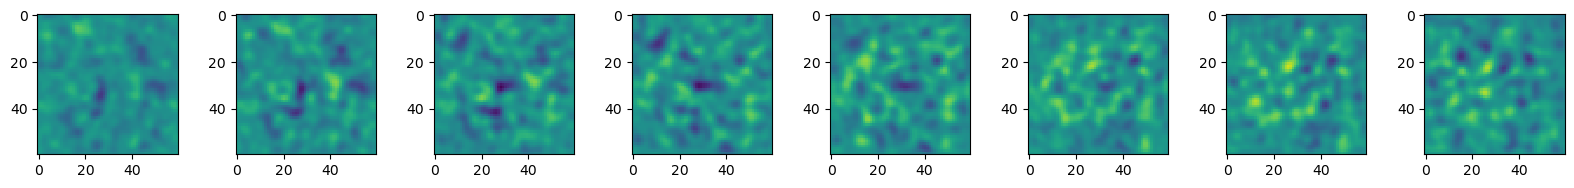

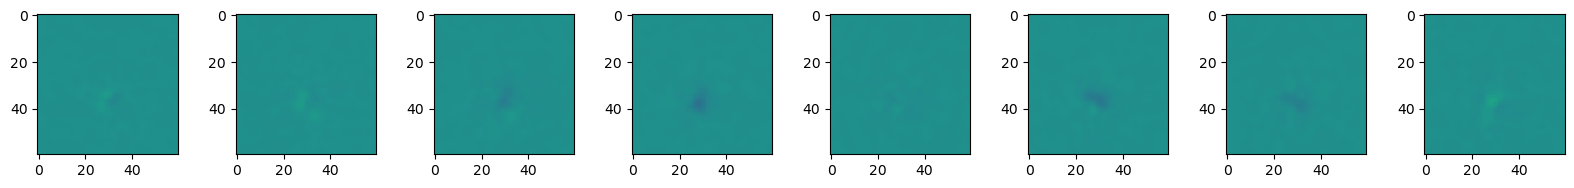

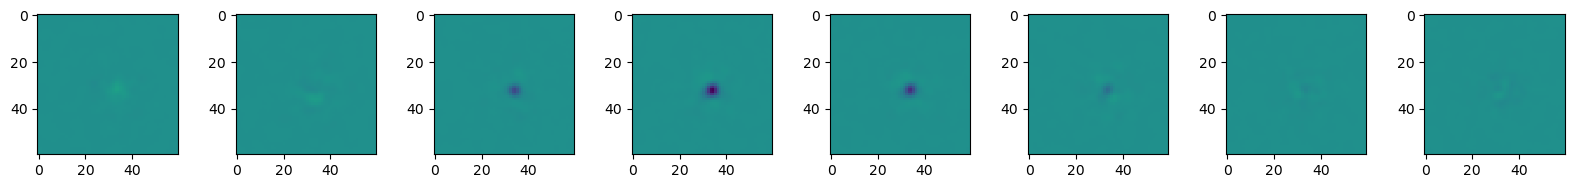

Cell   1: GQM (0.0285)
(60, 60, 12, 1) (60, 60, 12, 2)


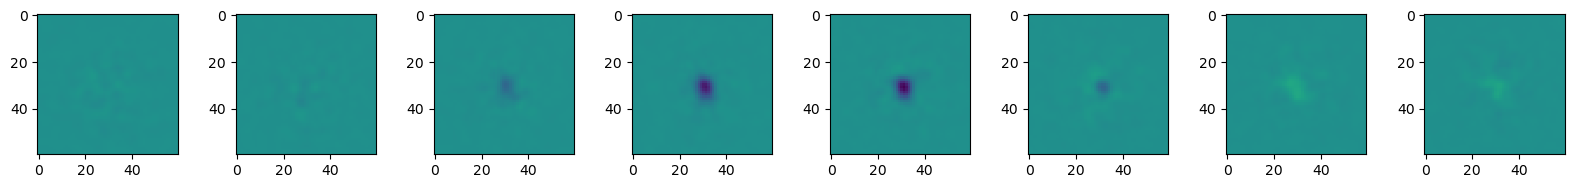

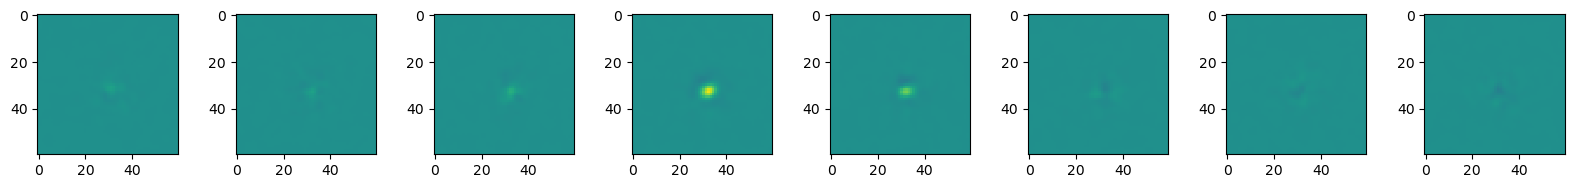

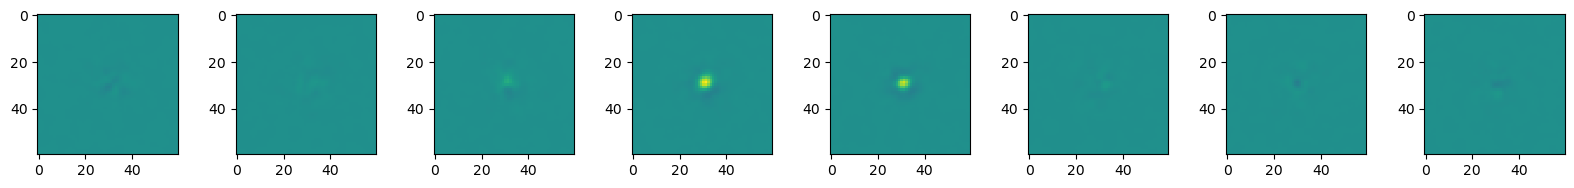

Cell   2: GQM (0.0016)
(60, 60, 12, 1) (60, 60, 12, 2)


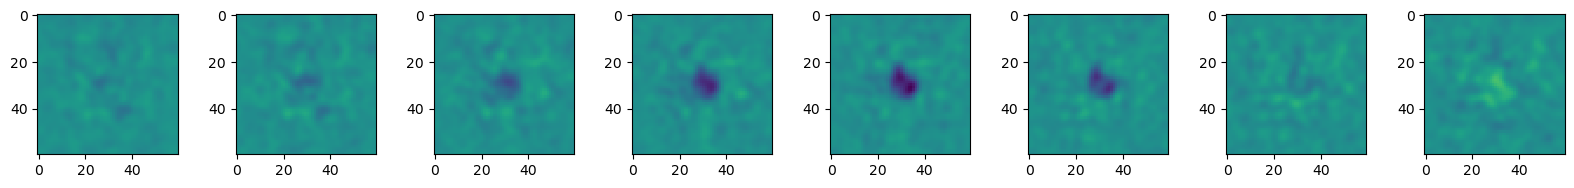

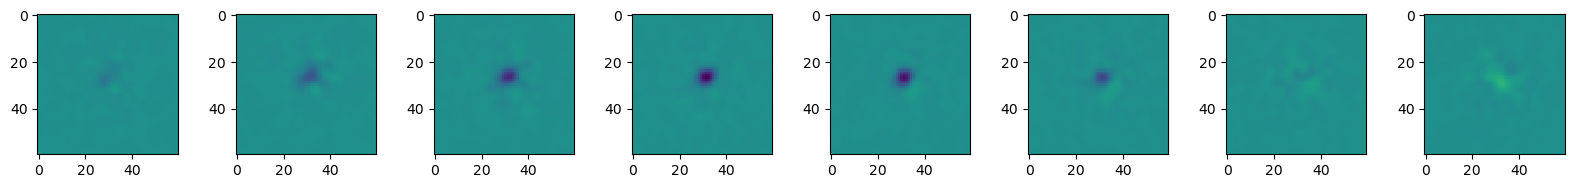

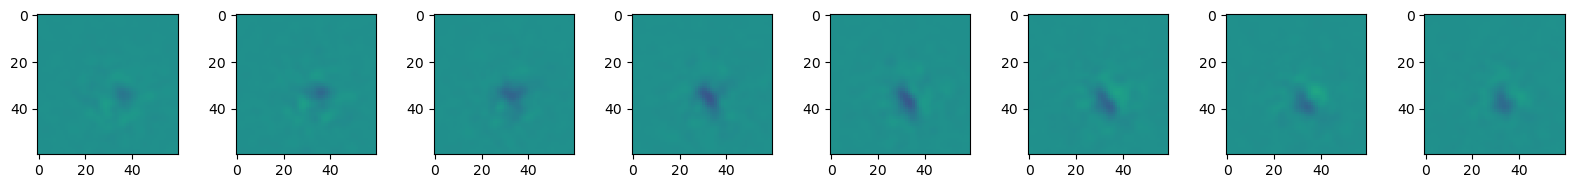

Cell   3: GQM (-0.0003)
(60, 60, 12, 1) (60, 60, 12, 2)


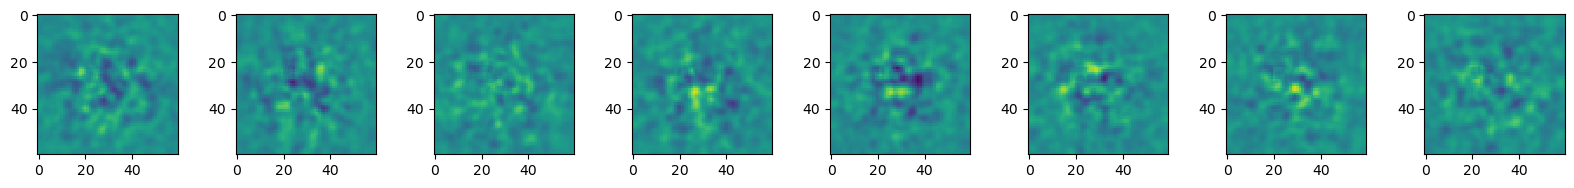

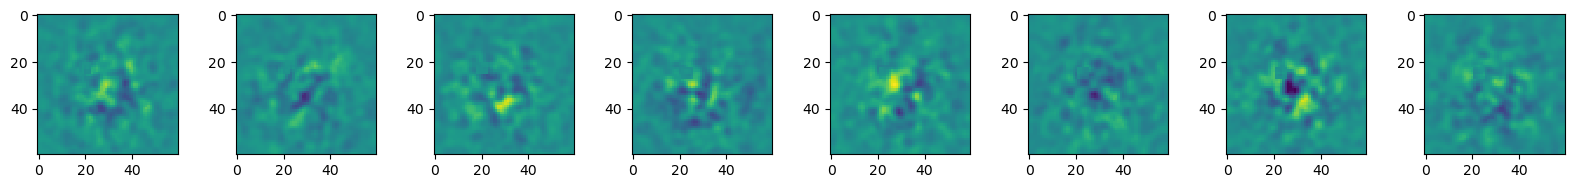

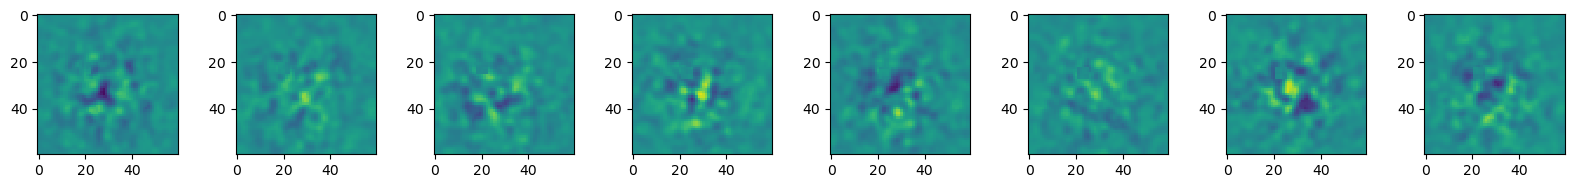

Cell   4: GQM (0.0067)
(60, 60, 12, 1) (60, 60, 12, 2)


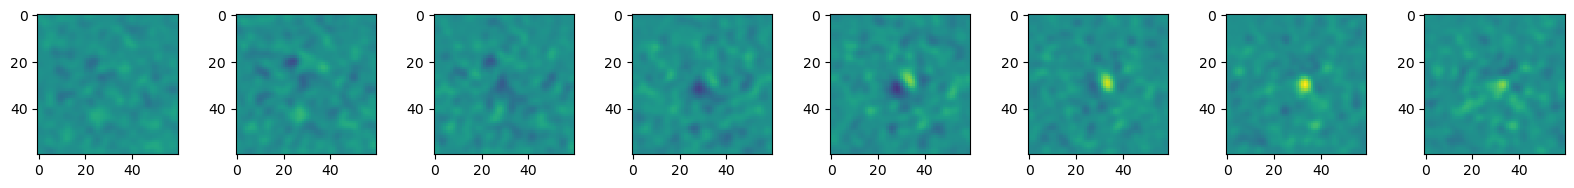

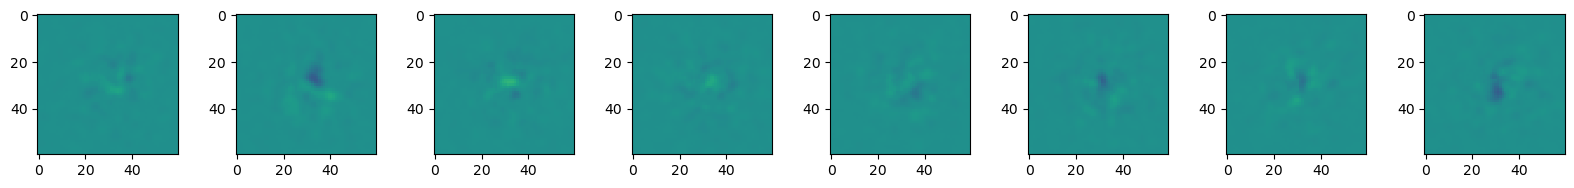

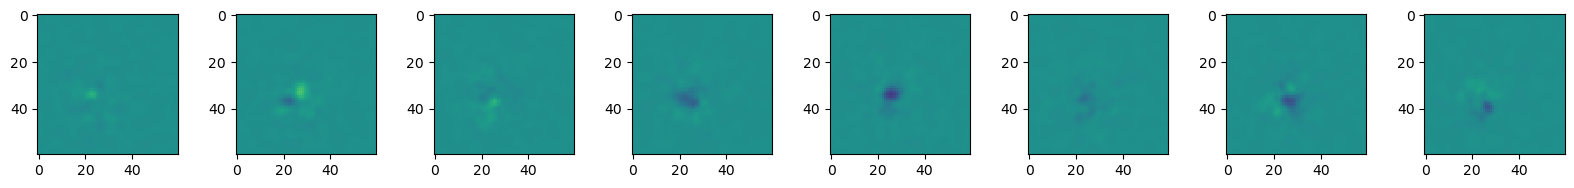

Cell   5: GQM (0.0081)
(60, 60, 12, 1) (60, 60, 12, 2)


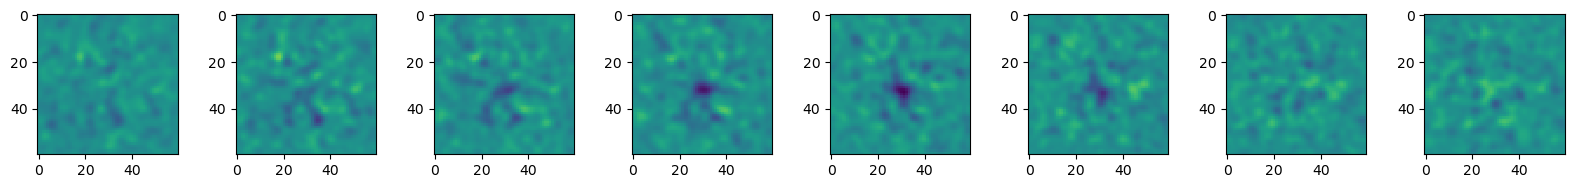

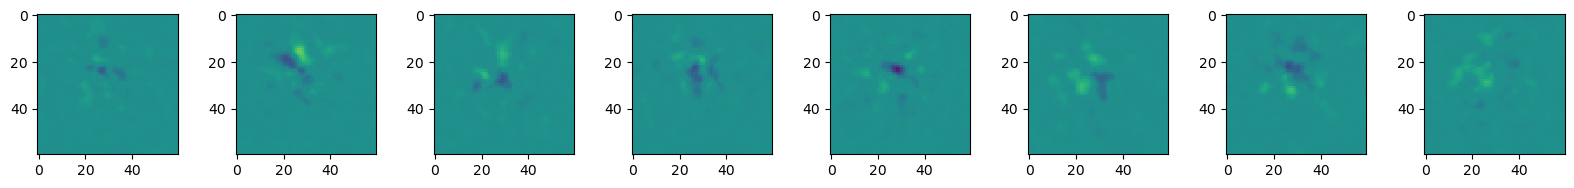

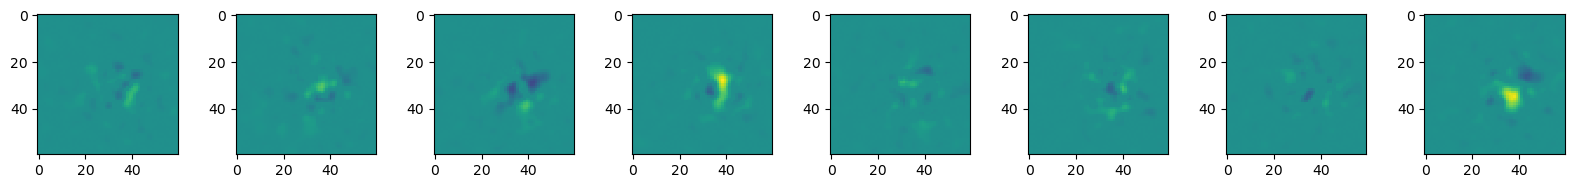

Cell   6: GQM (0.0668)
(60, 60, 12, 1) (60, 60, 12, 2)


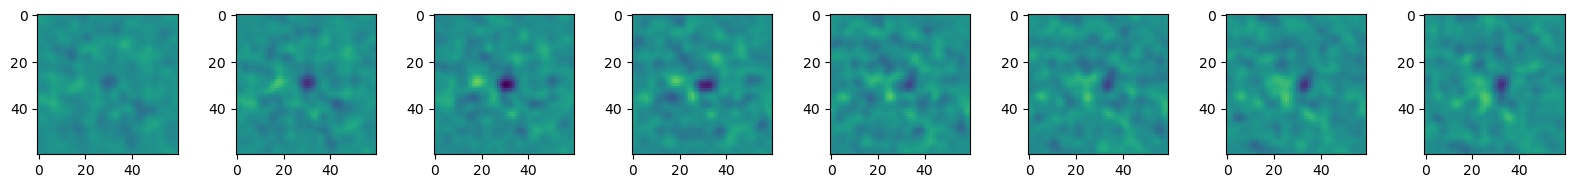

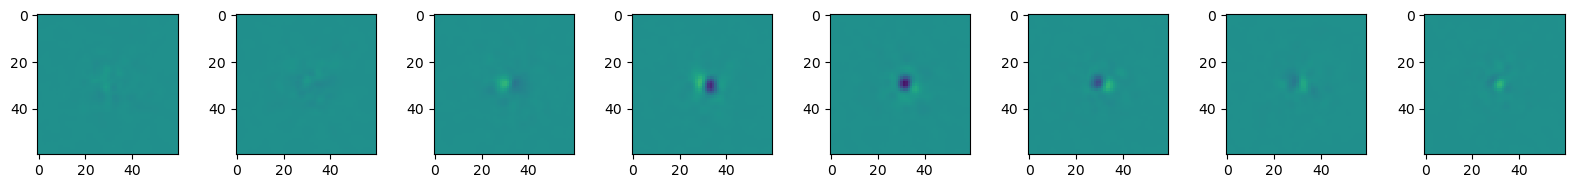

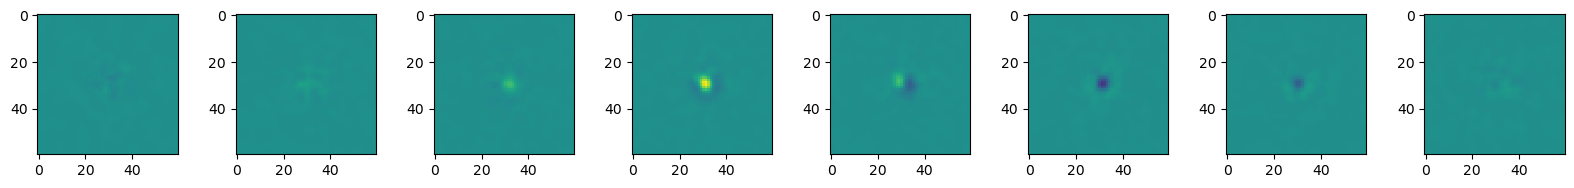

Cell   7: GQM (-0.0002)
(60, 60, 12, 1) (60, 60, 12, 2)


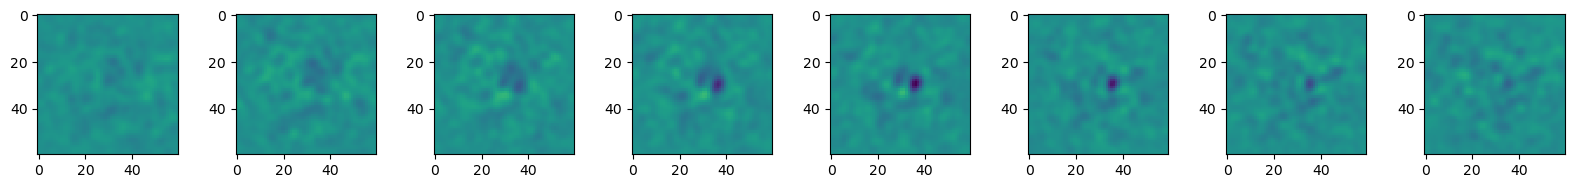

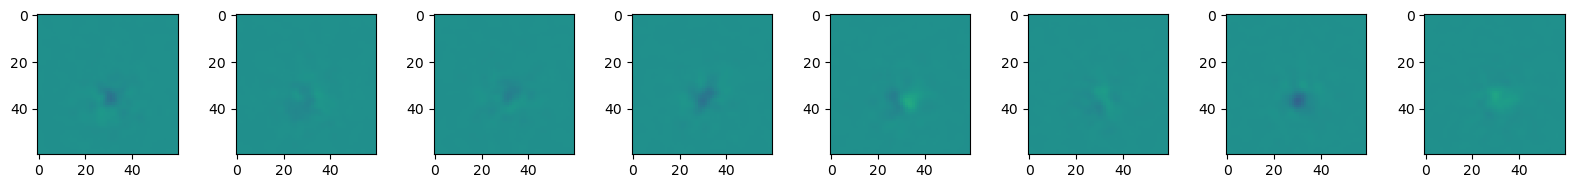

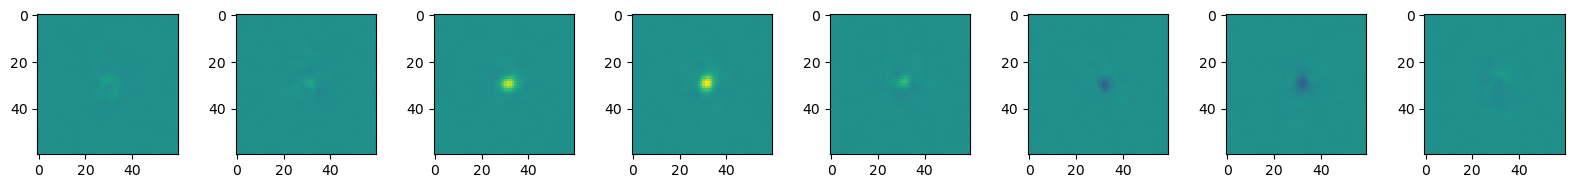

Cell   8: GQM (0.0090)
(60, 60, 12, 1) (60, 60, 12, 2)


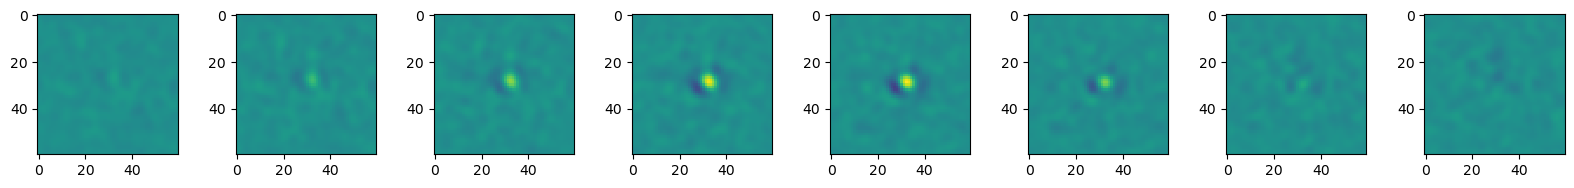

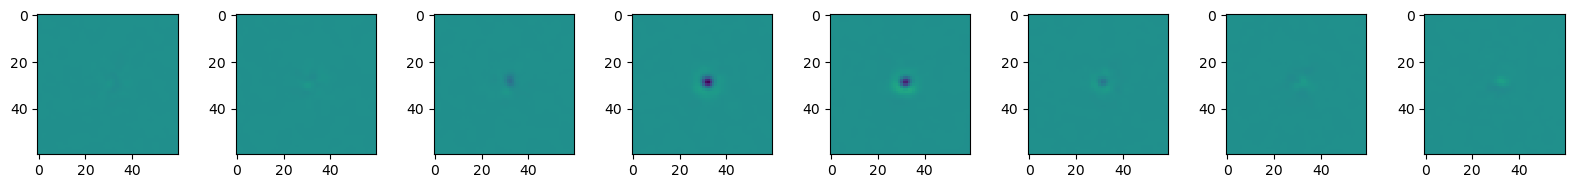

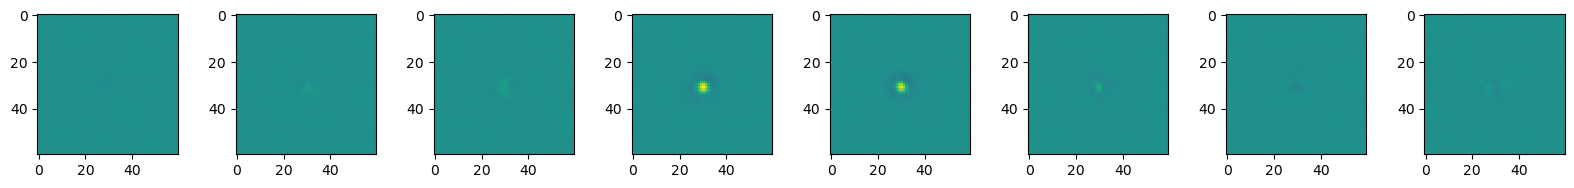

Cell   9: GQM (0.0822)
(60, 60, 12, 1) (60, 60, 12, 2)


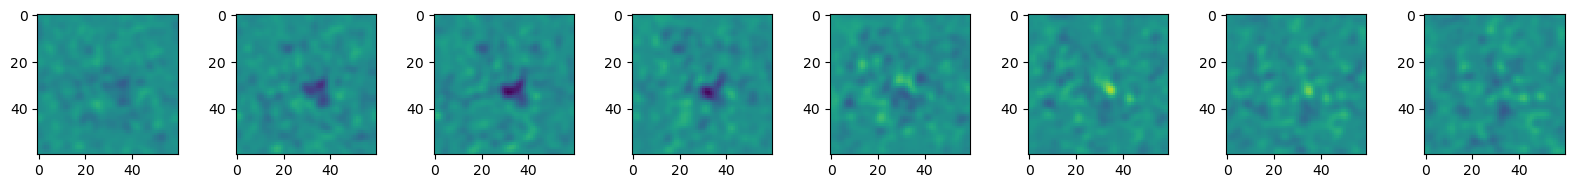

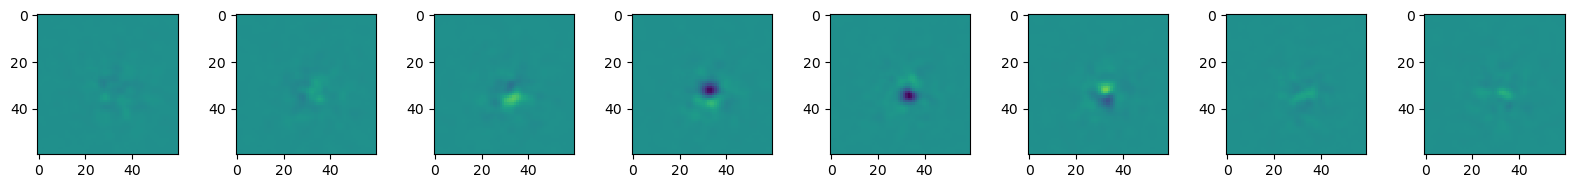

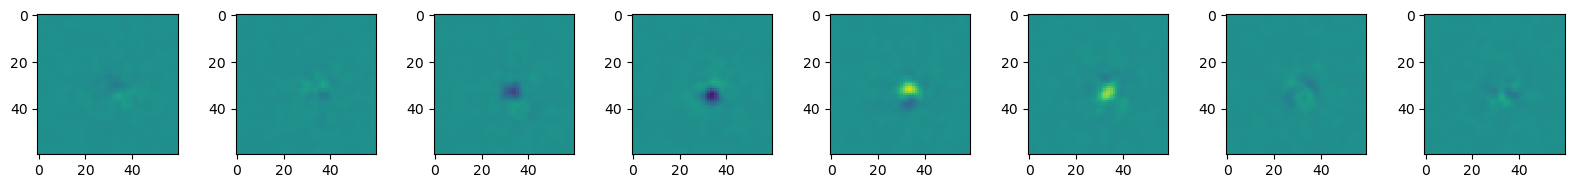

Cell  10: GQM (0.0021)
(60, 60, 12, 1) (60, 60, 12, 2)


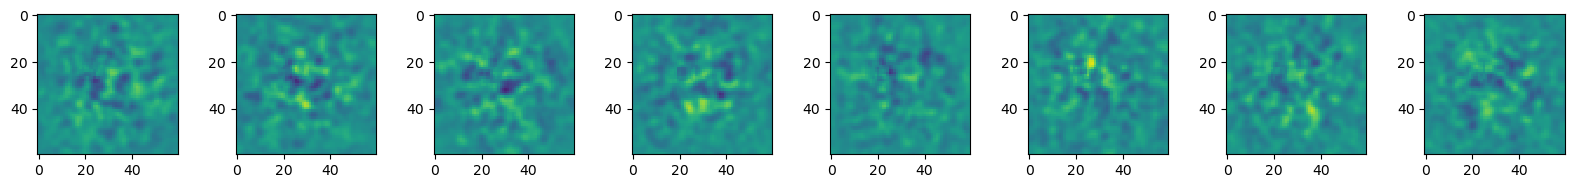

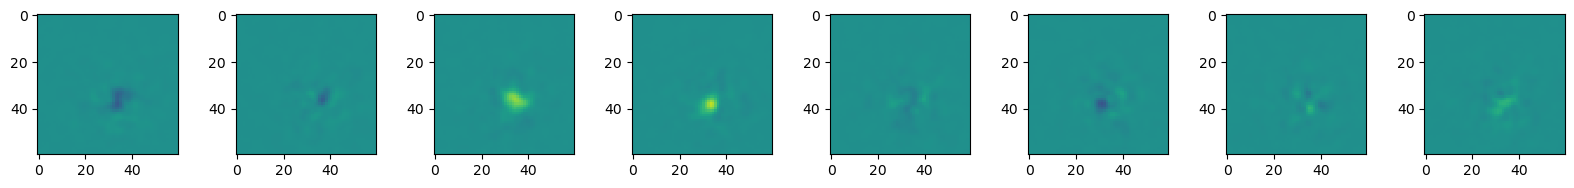

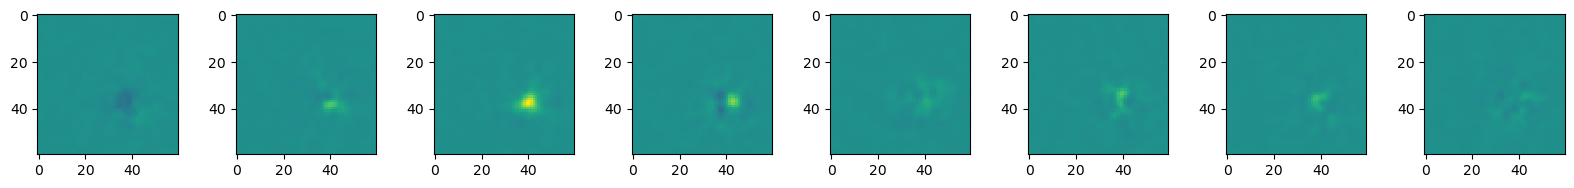

Cell  11: GQM (0.0020)
(60, 60, 12, 1) (60, 60, 12, 2)


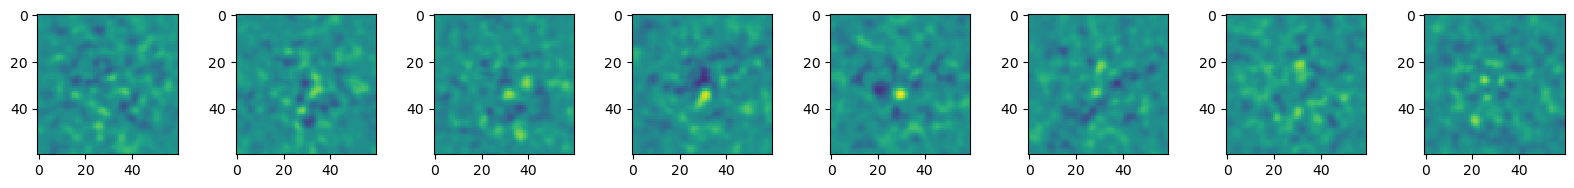

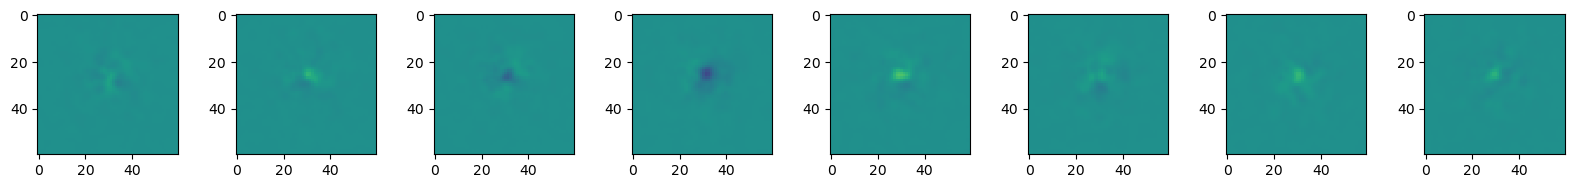

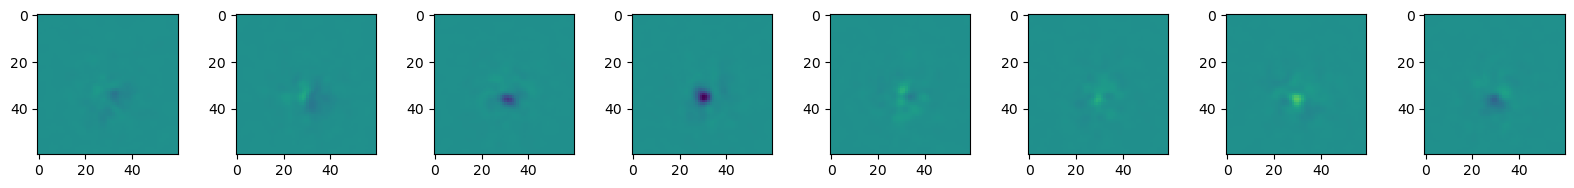

Cell  12: GQM (0.0033)
(60, 60, 12, 1) (60, 60, 12, 2)


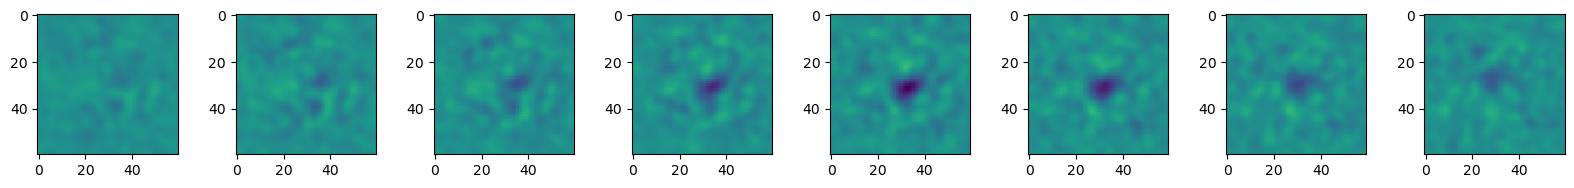

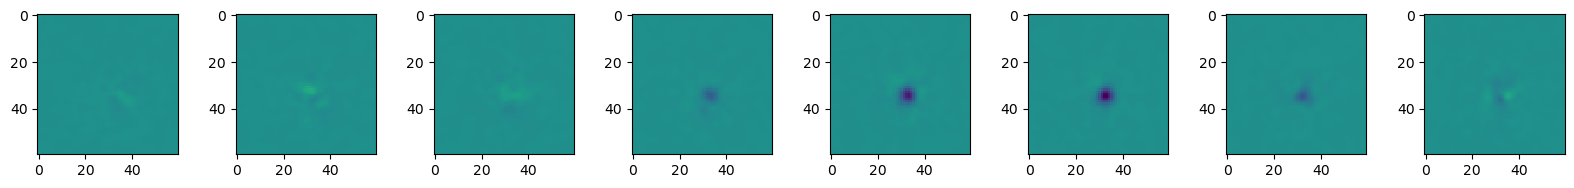

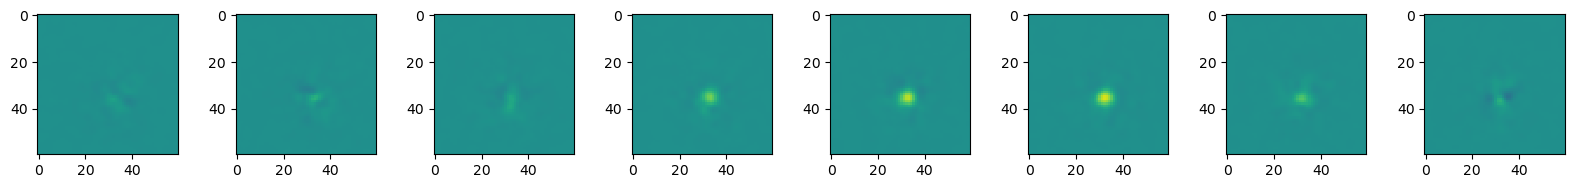

Cell  13: GQM (0.0008)
(60, 60, 12, 1) (60, 60, 12, 2)


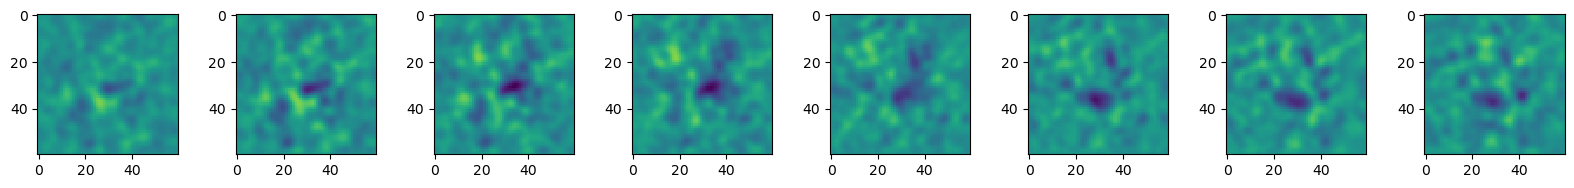

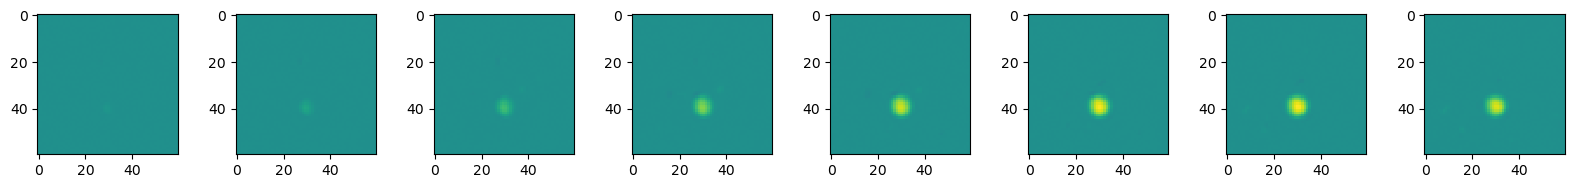

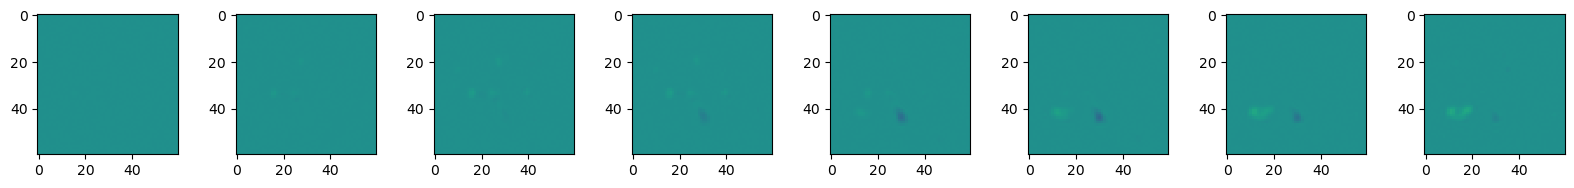

Cell  14: GQM (0.0245)
(60, 60, 12, 1) (60, 60, 12, 2)


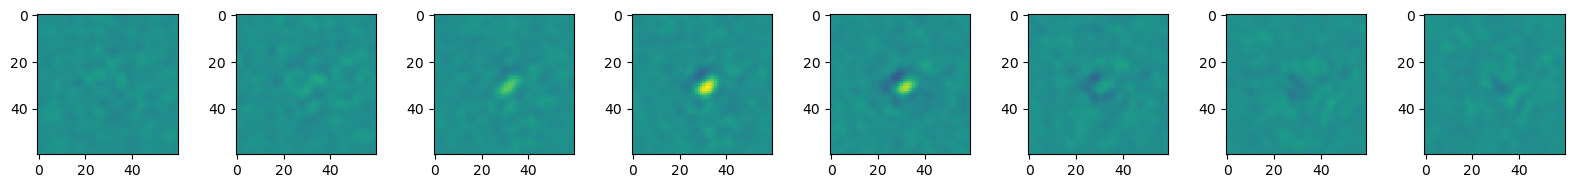

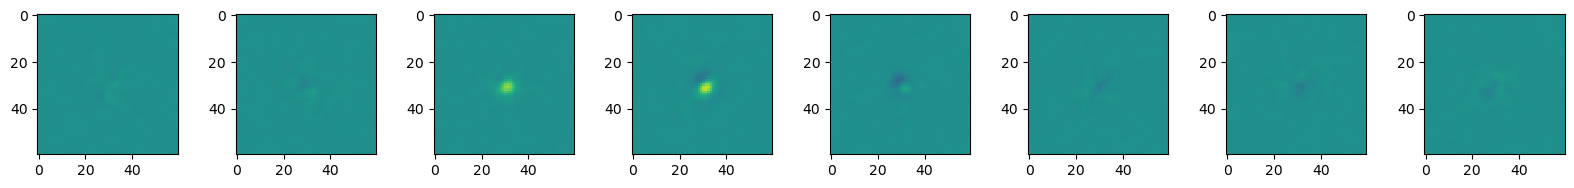

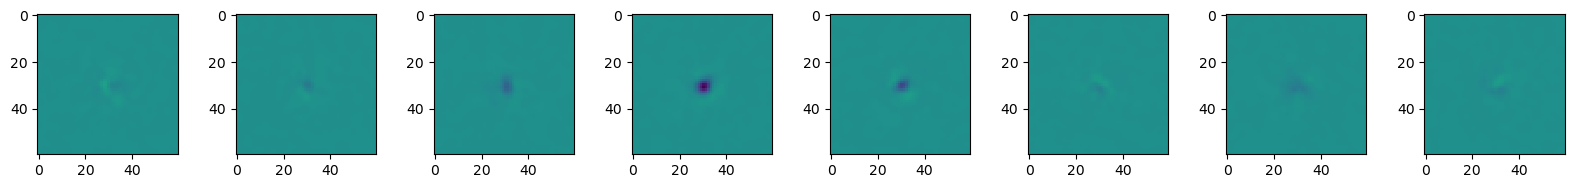

Cell  15: GQM (0.0226)
(60, 60, 12, 1) (60, 60, 12, 2)


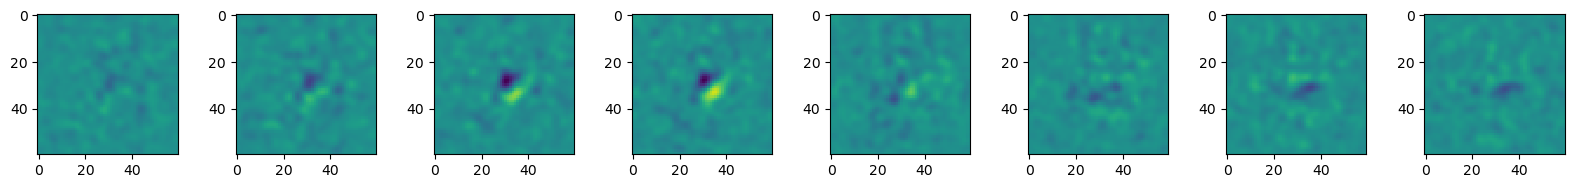

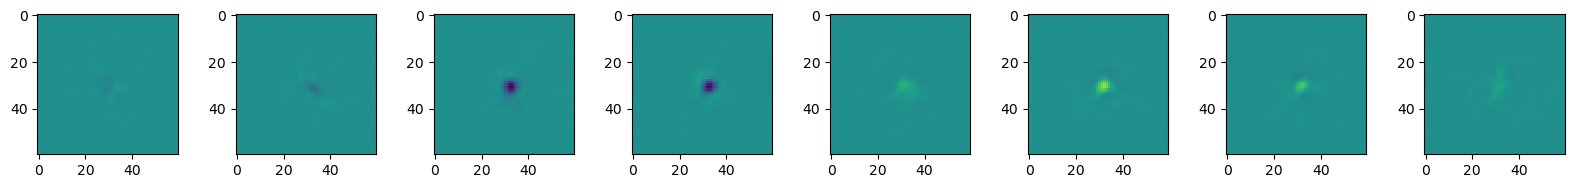

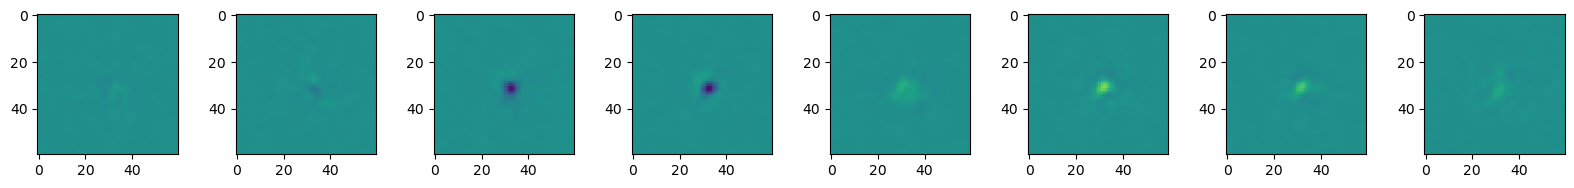

Cell  16: GQM (0.0122)
(60, 60, 12, 1) (60, 60, 12, 2)


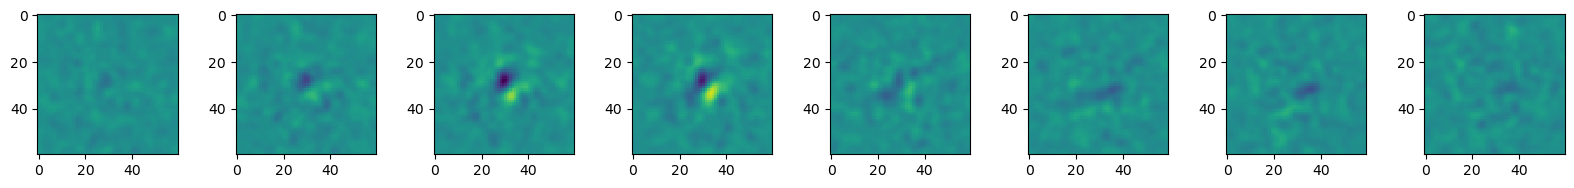

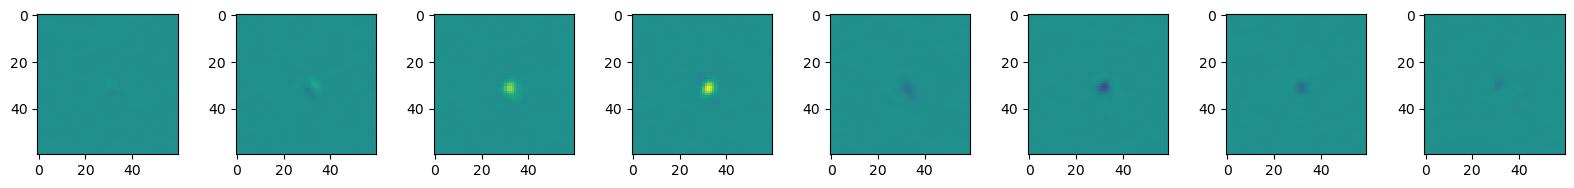

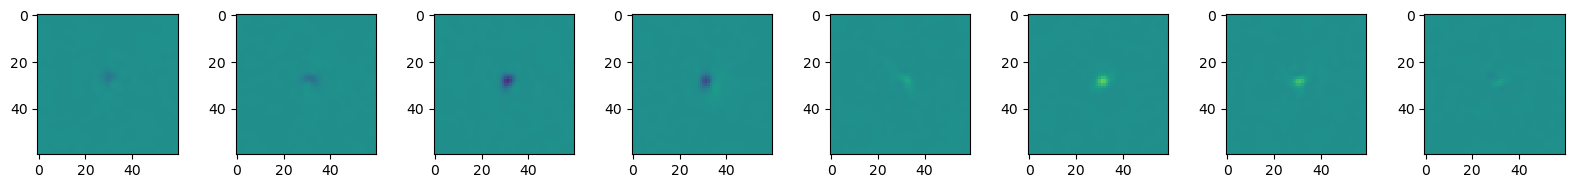

Cell  17: GQM (0.0522)
(60, 60, 12, 1) (60, 60, 12, 2)


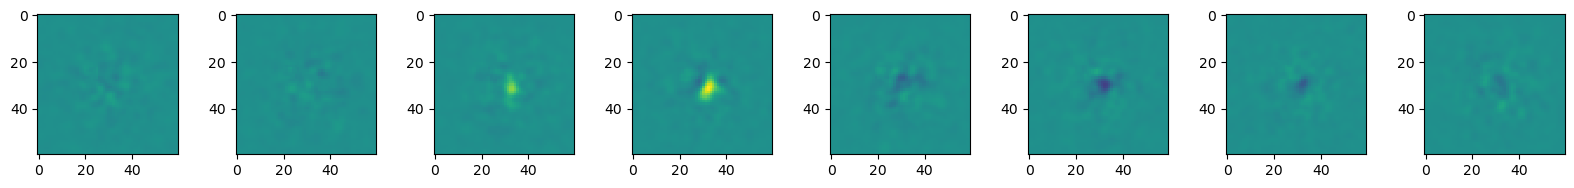

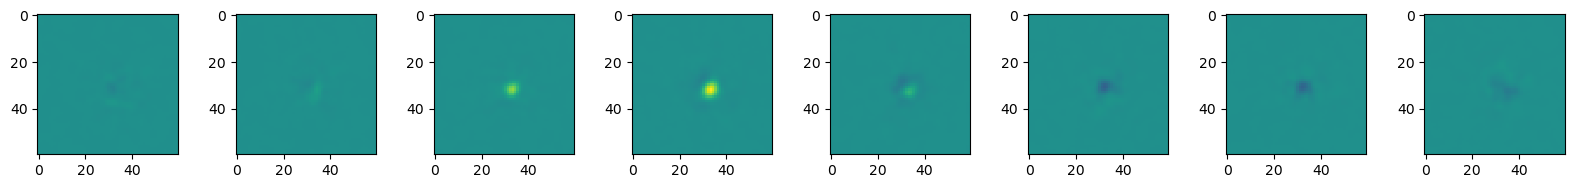

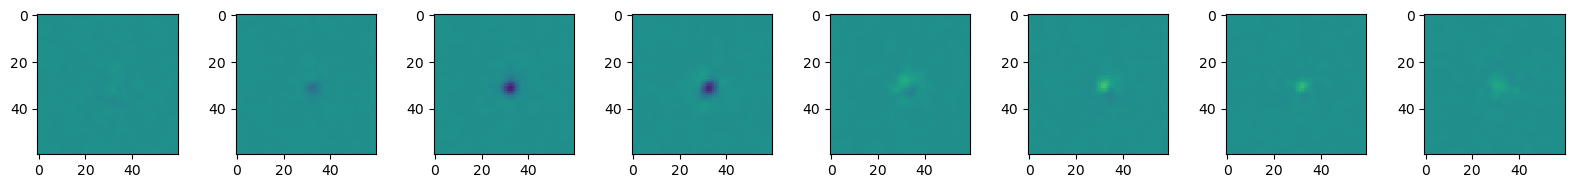

Cell  18: GQM (0.0021)
(60, 60, 12, 1) (60, 60, 12, 2)


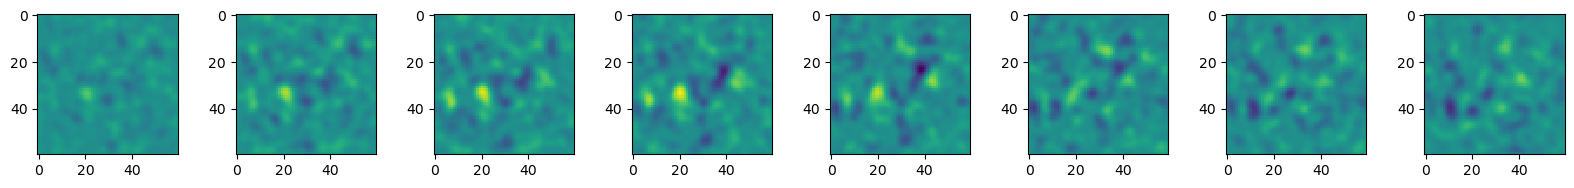

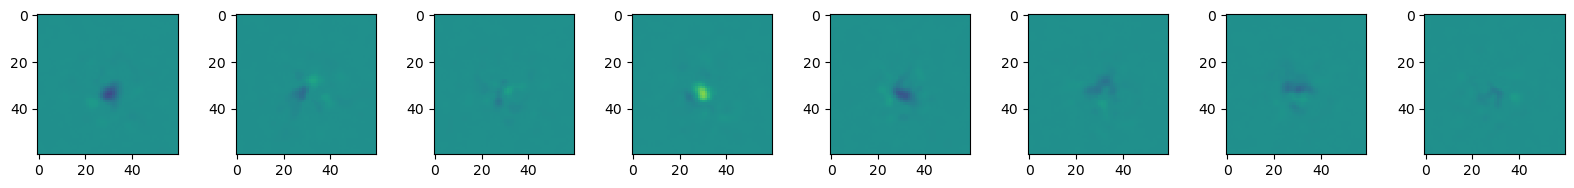

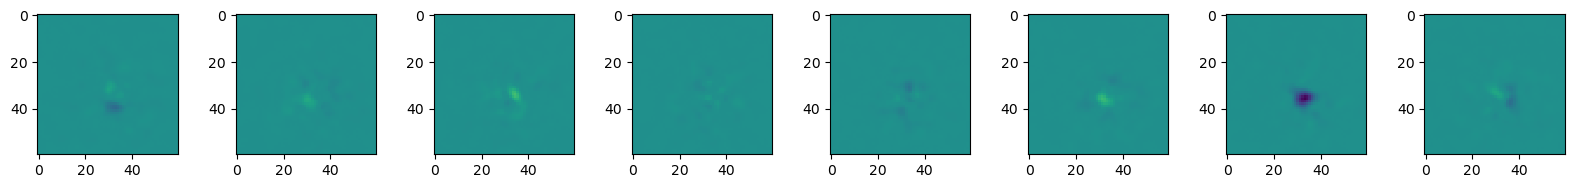

Cell  19: GQM (0.0371)
(60, 60, 12, 1) (60, 60, 12, 2)


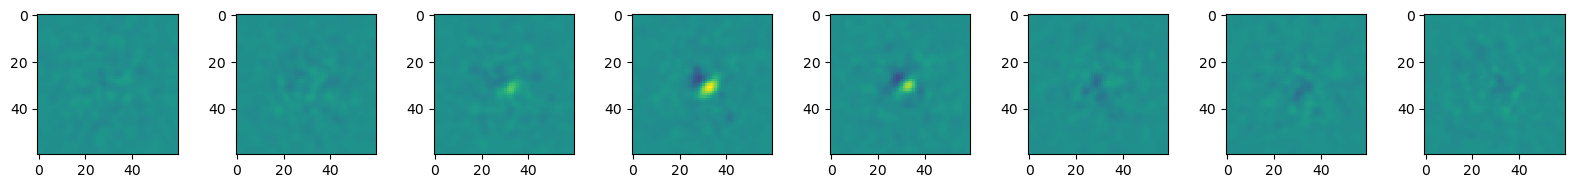

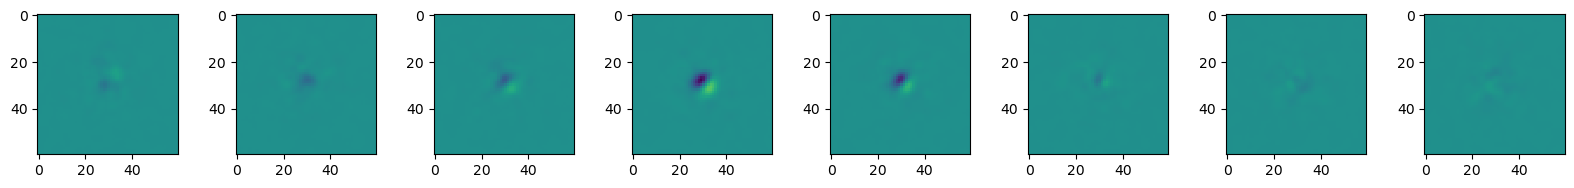

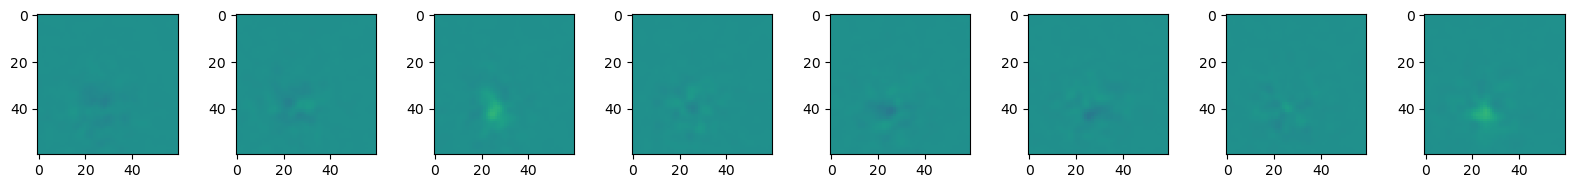

Cell  20: GQM (0.0005)
(60, 60, 12, 1) (60, 60, 12, 2)


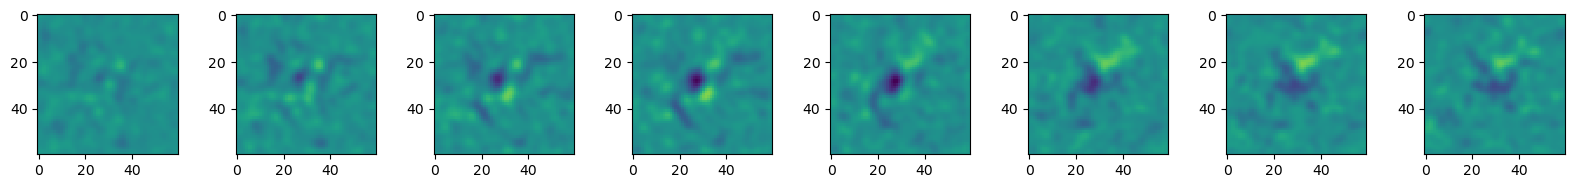

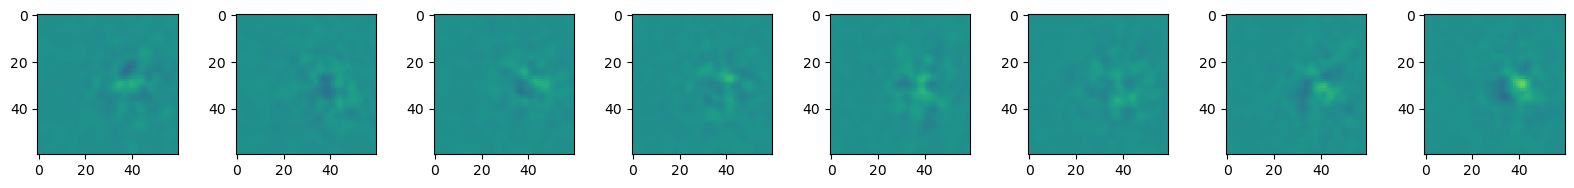

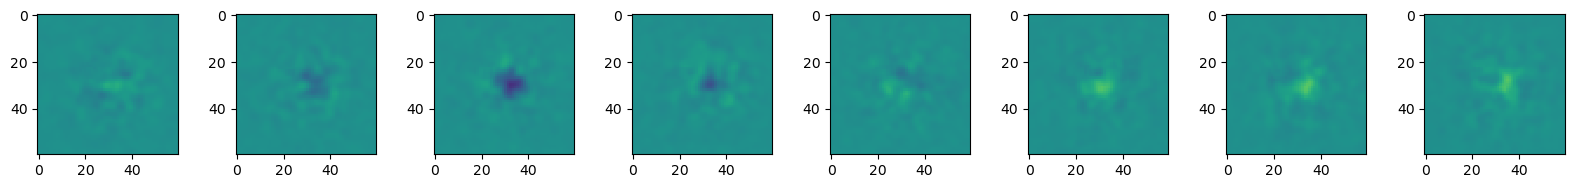

In [32]:
for cc in range(NCv):
    try:
        print( "Cell %3d: GQM (%2.4f)"% (cc, dan_gqms[cc].LLs) )
        w_lin = dan_gqms[cc].ndn_model.networks[0].layers[0].get_weights()
        w_quad = dan_gqms[cc].ndn_model.networks[2].layers[0].get_weights()
        print(w_lin.shape, w_quad.shape)
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_lin[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_lin)))
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_quad[:,:,num_lags-ll,0], aspect=1, max=np.max(abs(w_quad)))
        utils.subplot_setup(1,8)
        for ll in range(1,9):
            plt.subplot(1,8,ll)
            utils.imagesc(w_quad[:,:,num_lags-ll,1], aspect=1, max=np.max(abs(w_quad)))
        plt.show()
    except:
        pass

# STA

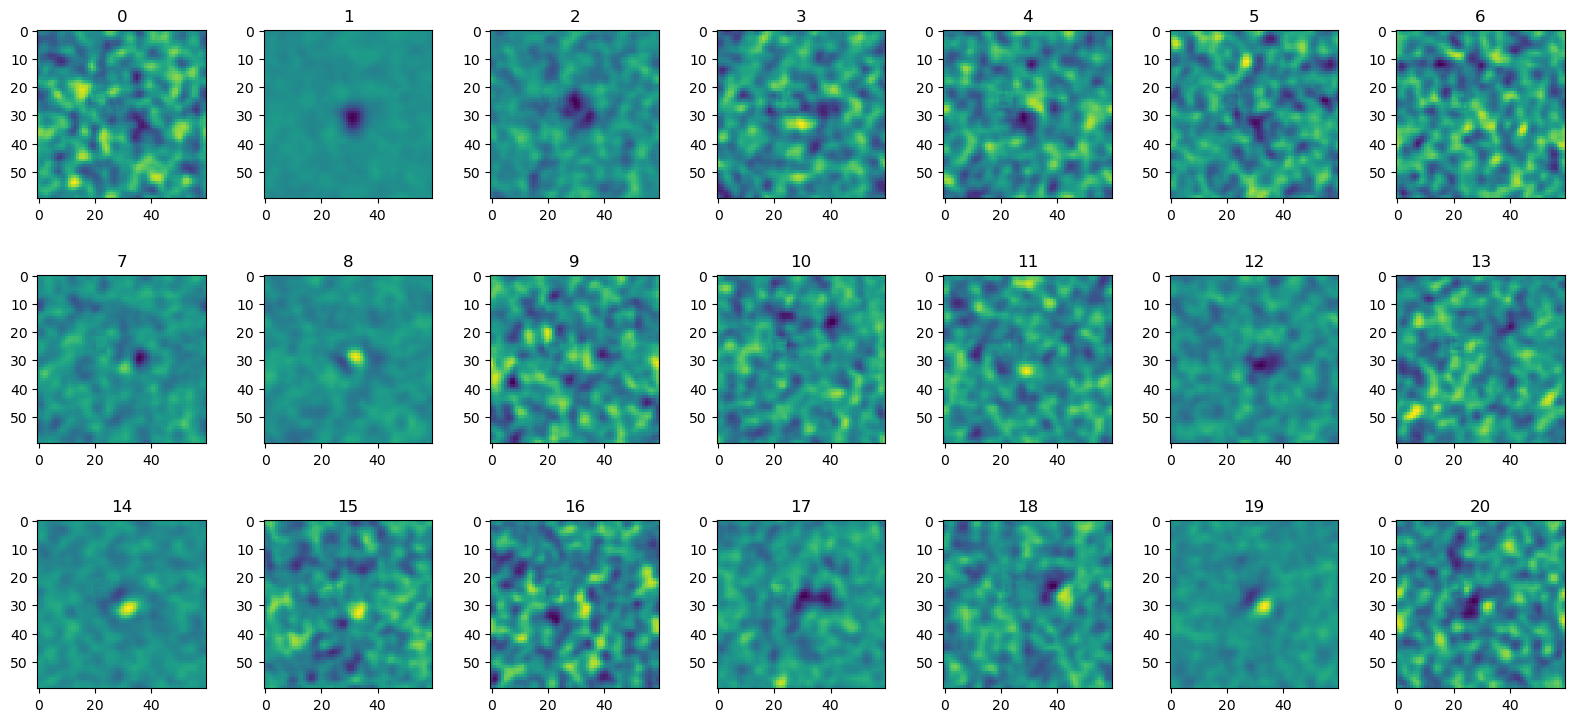

In [31]:
Reff = torch.mul(data.robs[:, vallam], data.dfs[:, vallam])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()

NCv = len(vallam)
ss(3,7)
for cc in range(NCv):
    plt.subplot(3,7, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

# simple vs. complex

In [11]:
dan_gqms = []
for cc in range(NCv):
    # continue if the file already exists
    if os.path.isfile('color_mods/best_GQM_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('color_mods/best_GQM_cc'+str(cc)+'.pkl', 'rb') as f:
            dan_gqms.append(pickle.load(f))
        continue

loading model 0
loading model 1
loading model 2
loading model 3
loading model 4
loading model 5
loading model 6
loading model 7
loading model 8
loading model 9
loading model 10
loading model 11
loading model 12
loading model 13
loading model 14
loading model 15
loading model 16
loading model 17
loading model 18
loading model 19
loading model 20


In [12]:
# -1 is bad fit, 0 is simple, 1 is in-between, 2 is complex
expected_complex_scores = [2, 1, 1, -1, 2, 
                           -1, 2, 2, 0, 2, 
                           2, 2, 1, 2, 0, 
                           1, 1, 1, 2, 0,
                           -1]

In [13]:
dfs = data.dfs.detach().numpy()

lin_corrs = []
quad_corrs = []
complex_raw_scores = []
complex_scores = []
lls = []

trial = 0
for cc in range(NCv):
    print(cc)
    ll = dan_gqms[cc].LLs
    model = dan_gqms[cc].ndn_model
    z_lin = model.networks[0].layers[0](data.stim[data.val_inds,:]) # lin
    z_lin = z_lin.cpu().detach().numpy().squeeze()*dfs[data.val_inds,vallam[cc]]
    z_quad = model.networks[2].layers[0](data.stim[data.val_inds,:]) # quad
    z_quad = np.sum(z_quad.cpu().detach().numpy(), axis=1)*dfs[data.val_inds, vallam[cc]]
    robs = data.robs[data.val_inds,vallam[cc]]*dfs[data.val_inds,vallam[cc]]
    robs = robs.detach().numpy()
    
    lls.append(ll)

    # rectify the linear
    z_lin = np.where(z_lin < 0, 0, z_lin)

    # min-max scale the activations
    z_lin = (z_lin - np.min(z_lin)) / (np.max(z_lin) - np.min(z_lin))
    z_quad = (z_quad - np.min(z_quad)) / (np.max(z_quad) - np.min(z_quad))

    # correlation between robs and z_lin and z_quad
    lin_corr = np.correlate(robs, z_lin)[0]
    quad_corr = np.correlate(robs, z_quad)[0]

    rect_lin_corr = 0 if lin_corr < 0 else lin_corr
    rect_quad_corr = 0 if quad_corr < 0 else quad_corr
    complex_score = rect_quad_corr / sum([rect_lin_corr, rect_quad_corr])
    
    lin_corrs.append(lin_corr)
    quad_corrs.append(quad_corr)
    complex_raw_scores.append(complex_score)
    
    if 0.45 - complex_score < 0.05:
        complex_scores.append(2)
    elif 0.45 - complex_score < -0.05:
        complex_scores.append(0)
    else:
        complex_scores.append(1)  
    
    print('Linear Correlation', lin_corr)
    print('Quadratic Correlation', quad_corr)
    print('Complex Score', complex_score)

    # fig = plt.figure(figsize=(15,5))
    # plt.plot(z_lin, label='lin')
    # plt.plot(z_quad, label='quad')
    # #plt.plot(robs, label='robs')
    # plt.legend()
    # plt.show()
    
# print the accuracy
print('Accuracy', sum([1 if complex_scores[cc] == expected_complex_scores[cc] else 0 for cc in range(NCv)]) / NCv)

0
Linear Correlation 59.575127
Quadratic Correlation 57.406185
Complex Score 0.49072953848583
1
Linear Correlation 1474.1907
Quadratic Correlation 1180.5544
Complex Score 0.4446959656187568
2
Linear Correlation 315.99155
Quadratic Correlation 330.57452
Complex Score 0.511277252209018
3
Linear Correlation 62.364502
Quadratic Correlation 35.65901
Complex Score 0.36378018355655894
4
Linear Correlation 68.008606
Quadratic Correlation 39.814365
Complex Score 0.3692568002039261
5
Linear Correlation 82.471634
Quadratic Correlation 56.899773
Complex Score 0.40826001581261867
6
Linear Correlation 91.52763
Quadratic Correlation 152.08008
Complex Score 0.6242826920637704
7
Linear Correlation 418.08224
Quadratic Correlation 320.83948
Complex Score 0.43419954754033446
8
Linear Correlation 1412.0115
Quadratic Correlation 1247.2626
Complex Score 0.4690237075226811
9
Linear Correlation 93.38634
Quadratic Correlation 110.009
Complex Score 0.5408629455524074
10
Linear Correlation 100.201096
Quadratic Co

In [ ]:
dfs = data.dfs.detach().numpy()

lin_corrs = []
quad_corrs = []
complex_raw_scores = []
complex_scores = []
lls = []

trial = 0
for cc in range(NCv):
    print(cc)
    ll = dan_gqms[cc].LLs
    model = dan_gqms[cc].ndn_model
    z_lin = model.networks[0].layers[0](data.stim[data.val_inds,:]) # lin
    z_lin = z_lin.cpu().detach().numpy().squeeze()*dfs[data.val_inds,vallam[cc]]
    z_quad = model.networks[2].layers[0](data.stim[data.val_inds,:]) # quad
    z_quad = np.sum(z_quad.cpu().detach().numpy(), axis=1)*dfs[data.val_inds, vallam[cc]]
    robs = data.robs[data.val_inds,vallam[cc]]*dfs[data.val_inds,vallam[cc]]
    robs = robs.detach().numpy()

    lls.append(ll)

    # rectify the linear
    z_lin = np.where(z_lin < 0, 0, z_lin)

    # min-max scale the activations
    z_lin = (z_lin - np.min(z_lin)) / (np.max(z_lin) - np.min(z_lin))
    z_quad = (z_quad - np.min(z_quad)) / (np.max(z_quad) - np.min(z_quad))

    # correlation between robs and z_lin and z_quad
    lin_corr = np.correlate(robs, z_lin)[0]
    quad_corr = np.correlate(robs, z_quad)[0]

    rect_lin_corr = 0 if lin_corr < 0 else lin_corr
    rect_quad_corr = 0 if quad_corr < 0 else quad_corr
    complex_score = rect_quad_corr / sum([rect_lin_corr, rect_quad_corr])

    lin_corrs.append(lin_corr)
    quad_corrs.append(quad_corr)
    complex_raw_scores.append(complex_score)
    
    # TODO: try ablation measure
    

    if 0.45 - complex_score < 0.05:
        complex_scores.append(2)
    elif 0.45 - complex_score < -0.05:
        complex_scores.append(0)
    else:
        complex_scores.append(1)

    print('Linear Correlation', lin_corr)
    print('Quadratic Correlation', quad_corr)
    print('Complex Score', complex_score)

    # fig = plt.figure(figsize=(15,5))
    # plt.plot(z_lin, label='lin')
    # plt.plot(z_quad, label='quad')
    # #plt.plot(robs, label='robs')
    # plt.legend()
    # plt.show()

# print the accuracy
print('Accuracy', sum([1 if complex_scores[cc] == expected_complex_scores[cc] else 0 for cc in range(NCv)]) / NCv)

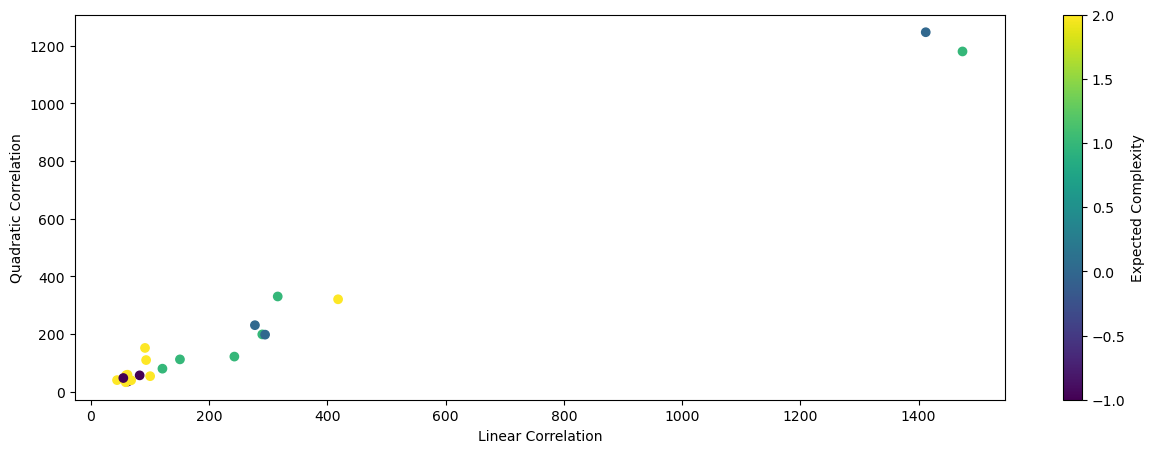

In [10]:
# plot the linear and quadratic and color by the expected complexity
fig = plt.figure(figsize=(15,5))
#plt.scatter(lin_corrs, quad_corrs, c=lls)
plt.scatter(lin_corrs, quad_corrs, c=expected_complex_scores)
plt.xlabel('Linear Correlation')
plt.ylabel('Quadratic Correlation')
# show a colorbar
cbar = plt.colorbar()
#cbar.set_label('Log Likelihood')
cbar.set_label('Expected Complexity')
plt.show()

In [11]:
# print the correlations and the expected complex scores
for i, (lin, quad, exp) in enumerate(zip(lin_corrs, quad_corrs, expected_complex_scores)):
    print(i, lin, quad, exp)

0 59.575127 57.406185 2
1 1474.1907 1180.5544 1
2 315.99155 330.57452 1
3 62.364502 35.65901 -1
4 68.008606 39.814365 2
5 82.471634 56.899773 -1
6 91.52763 152.08008 2
7 418.08224 320.83948 2
8 1412.0115 1247.2626 0
9 93.38634 110.009 2
10 100.201096 54.111 2
11 61.83868 59.178543 2
12 289.86505 199.01413 1
13 58.904144 33.104126 2
14 277.4257 230.96368 0
15 121.015434 80.103874 1
16 150.62544 112.36183 1
17 242.6694 122.0296 1
18 44.23893 40.46495 2
19 294.59393 198.16766 0
20 54.84016 47.71021 -1


# hist

(array([1., 2., 2., 0., 2., 2., 2., 1., 1., 3., 2., 0., 1., 0., 1., 0., 0.,
        0., 0., 1.]),
 array([0.33460361, 0.34908756, 0.36357151, 0.37805547, 0.39253942,
        0.40702338, 0.42150733, 0.43599129, 0.45047524, 0.46495919,
        0.47944315, 0.4939271 , 0.50841106, 0.52289501, 0.53737897,
        0.55186292, 0.56634687, 0.58083083, 0.59531478, 0.60979874,
        0.62428269]),
 <BarContainer object of 20 artists>)

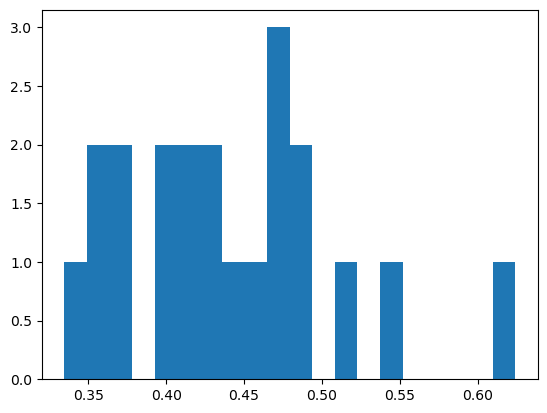

In [14]:
plt.hist(complex_raw_scores, bins=20)

# captum

In [119]:
from captum.attr import IntegratedGradients, NeuronIntegratedGradients, Saliency, DeepLift, NoiseTunnel, NeuronDeepLift
from captum.attr import visualization as viz

In [106]:
ind = 200
cc = 8
# combine the inputs going in, and split into dictionary when passing to the model
def stim_layer(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return dan_gqms[cc].ndn_model.networks[0].layers[0](stim_inp)

def stimq_layer(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return dan_gqms[cc].ndn_model.networks[2].layers[0](stim_inp)

def net(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return dan_gqms[cc].ndn_model({'stim':stim_inp, 'Xdrift':Xdrift_inp})

def net_zero(inpu):
    dan_gqms[cc].ndn_model.zero_grad()
    return net(inpu)




inps = torch.hstack([data.stim[data.val_inds,:], data.Xdrift[data.val_inds,:]])
inp = inps[ind].unsqueeze(0)
inp.requires_grad = True

#pred = net(inp)
robs = data.robs[data.val_inds,vallam[cc]]*dfs[data.val_inds,vallam[cc]]
rob = robs[ind].unsqueeze(0).unsqueeze(0)

inp.shape, rob.shape, data.robs.shape, data[ind]['Xdrift'].shape

(torch.Size([1, 3644]),
 torch.Size([1, 1]),
 torch.Size([167520, 239]),
 torch.Size([240, 44]))

In [108]:
net_zero(inp), stimq_layer(inp), stim_layer(inp)

(tensor([[0.3887]], grad_fn=<SoftplusBackward0>),
 tensor([[0.0002, 0.0001]], grad_fn=<PowBackward0>),
 tensor([[0.0112]], grad_fn=<SelectBackward0>))

In [79]:
original_image = inp[:, :3600].squeeze().cpu().detach().numpy().reshape(60,60, 1)

saliency = Saliency(net)
grads = saliency.attribute(inp)
grads = grads.squeeze().cpu().detach().numpy()
grads = grads[:3600].reshape(60,60, 1)

original_image.shape, grads.shape

((60, 60, 1), (60, 60, 1))

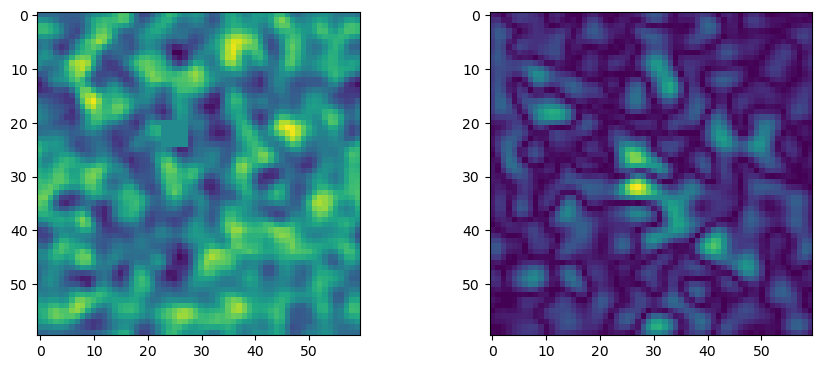

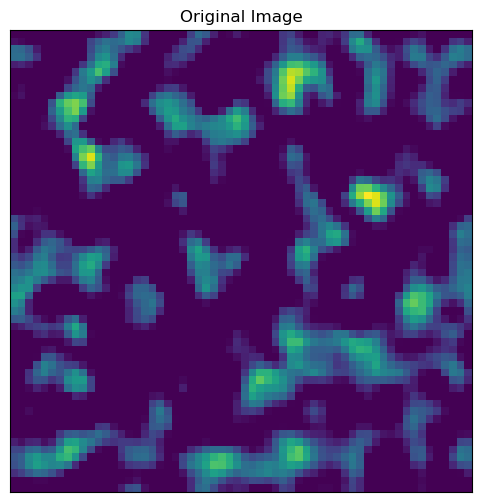

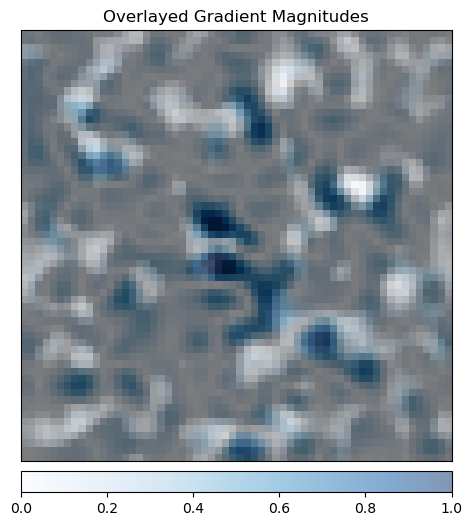

In [80]:
fig = plt.figure(figsize=(10,5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)
plt.subplot(grid[0, 0])
plt.imshow(inp[:,:3600].squeeze().cpu().detach().numpy().reshape(60,60))
plt.subplot(grid[0, 1])
plt.imshow(grads[:3600].reshape(60,60))
plt.show()

_ = viz.visualize_image_attr(None, original_image,
                             method="original_image", title="Original Image")
_ = viz.visualize_image_attr(grads, original_image, 
                             method="blended_heat_map", sign="absolute_value",
                             show_colorbar=True, title="Overlayed Gradient Magnitudes")

torch.Size([1, 3644])
inpu torch.Size([50, 3644]) stim_inp torch.Size([50, 3600]) Xdrift_inp torch.Size([50, 44])
inpu torch.Size([1, 3644]) stim_inp torch.Size([1, 3600]) Xdrift_inp torch.Size([1, 44])
inpu torch.Size([1, 3644]) stim_inp torch.Size([1, 3600]) Xdrift_inp torch.Size([1, 44])
Approximation delta:  tensor([0.0983], dtype=torch.float64)


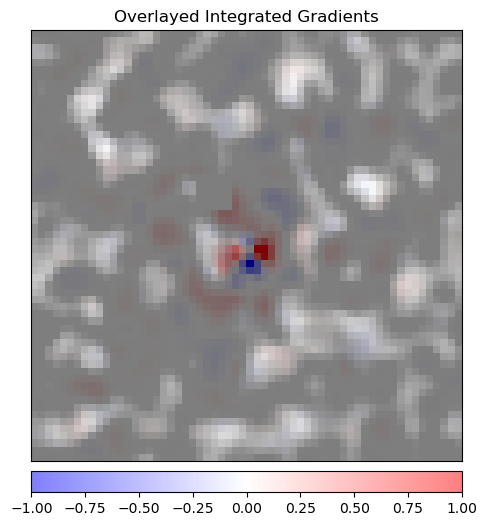

In [88]:
print(inp.shape)

ig = IntegratedGradients(net_zero)
attr_ig, delta = ig.attribute(inp,
                              baselines=inp * 0,
                              return_convergence_delta=True)
attr_ig = np.reshape(attr_ig[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))
print('Approximation delta: ', abs(delta))

_ = viz.visualize_image_attr(attr_ig, original_image, cmap='bwr',
                             method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Overlayed Integrated Gradients")

torch.Size([1, 3644])
inpu torch.Size([5000, 3644]) stim_inp torch.Size([5000, 3600]) Xdrift_inp torch.Size([5000, 44])


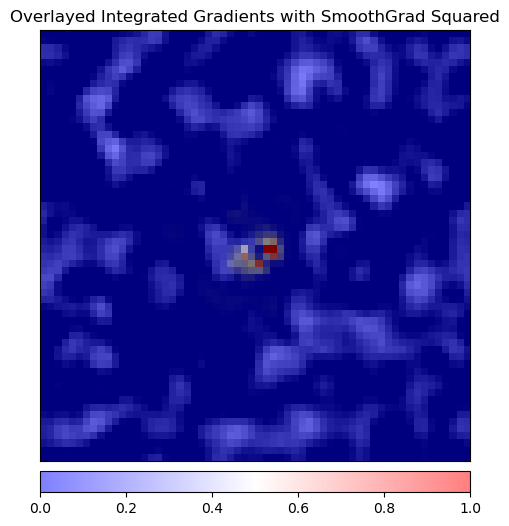

In [94]:
print(inp.shape)

ig = IntegratedGradients(net_zero)
nt = NoiseTunnel(ig)
attr_ig_nt = nt.attribute(inp,
                              baselines=inp * 0,
                              nt_type='smoothgrad_sq',
                              nt_samples=100, stdevs=0.2)
attr_ig_nt = np.reshape(attr_ig_nt[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

_ = viz.visualize_image_attr(attr_ig_nt, original_image, cmap='bwr',
                             method="blended_heat_map", sign="absolute_value", outlier_perc=10,
                             show_colorbar=True, title="Overlayed Integrated Gradients with SmoothGrad Squared")

inpu torch.Size([50, 3644]) stim_inp torch.Size([50, 3600]) Xdrift_inp torch.Size([50, 44])
inpu torch.Size([1, 3644]) stim_inp torch.Size([1, 3600]) Xdrift_inp torch.Size([1, 44])
inpu torch.Size([1, 3644]) stim_inp torch.Size([1, 3600]) Xdrift_inp torch.Size([1, 44])
Approximation delta:  tensor([0.0983], dtype=torch.float64)


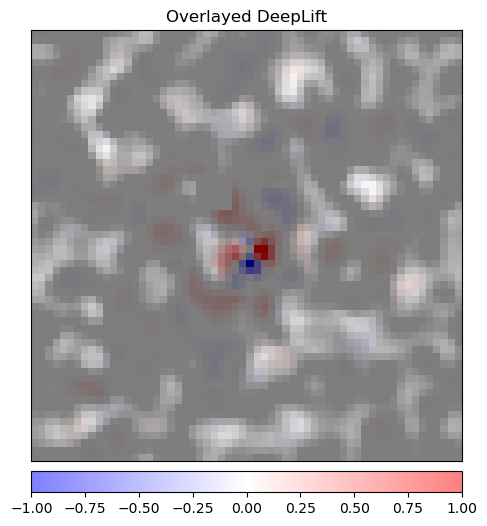

In [91]:
dl = DeepLift(net_zero)
attr_dl, delta = ig.attribute(inp,
                              baselines=inp * 0,
                              return_convergence_delta=True)
attr_dl = np.reshape(attr_dl[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))
print('Approximation delta: ', abs(delta))

_ = viz.visualize_image_attr(attr_dl, original_image, cmap='bwr',
                             method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Overlayed DeepLift")

# neuron IGs

torch.Size([1, 3644])


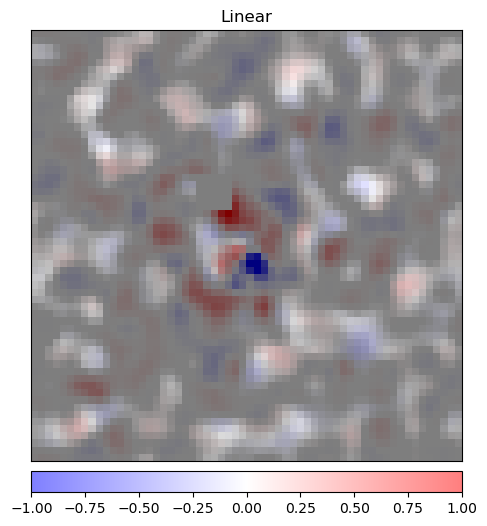

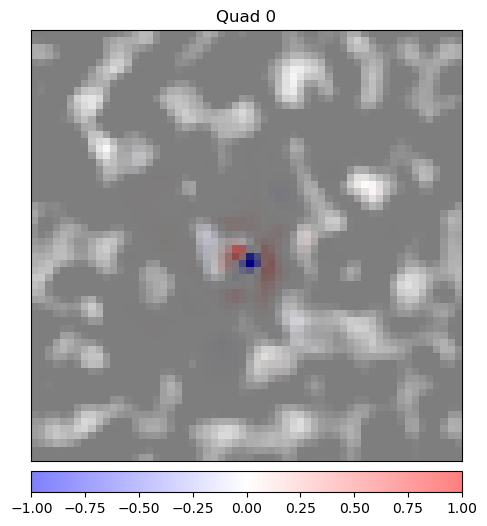

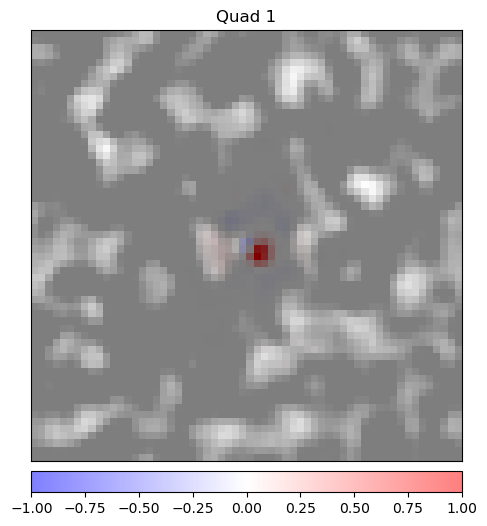

In [121]:
print(inp.shape)

neuron_ig_lin = NeuronIntegratedGradients(net_zero, dan_gqms[cc].ndn_model.networks[0].layers[0])
attr_ig_lin = neuron_ig_lin.attribute(inp,
                              baselines=inp * 0,
                              neuron_selector=0)
attr_ig_lin = np.reshape(attr_ig_lin[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

neuron_ig_q0 = NeuronIntegratedGradients(net_zero, dan_gqms[cc].ndn_model.networks[2].layers[0])
attr_ig_q0 = neuron_ig_q0.attribute(inp,
                              baselines=inp * 0,
                              neuron_selector=0)
attr_ig_q0 = np.reshape(attr_ig_q0[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

neuron_ig_q1 = NeuronIntegratedGradients(net_zero, dan_gqms[cc].ndn_model.networks[2].layers[0])
attr_ig_q1 = neuron_ig_q1.attribute(inp,
                              baselines=inp * 0,
                              neuron_selector=1)
attr_ig_q1 = np.reshape(attr_ig_q1[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

_ = viz.visualize_image_attr(attr_ig_lin, original_image, cmap='bwr',
                             method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Linear")

_ = viz.visualize_image_attr(attr_ig_q0, original_image, cmap='bwr',
                             method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Quad 0")

_ = viz.visualize_image_attr(attr_ig_q1, original_image, cmap='bwr',
                             method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Quad 1")

# neuron DLs

In [120]:
neuron_dl_lin = NeuronDeepLift(net_zero, dan_gqms[cc].ndn_model.networks[0].layers[0])
attr_dl_lin = neuron_dl_lin.attribute(inp,
                                      baselines=inp * 0,
                                      neuron_selector=0)
attr_dl_lin = np.reshape(attr_dl_lin[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

neuron_dl_q0 = NeuronDeepLift(net_zero, dan_gqms[cc].ndn_model.networks[2].layers[0])
attr_dl_q0 = neuron_dl_q0.attribute(inp,
                                    baselines=inp * 0,
                                    neuron_selector=0)
attr_dl_q0 = np.reshape(attr_dl_q0[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

neuron_dl_q1 = NeuronDeepLift(net_zero, dan_gqms[cc].ndn_model.networks[2].layers[0])
attr_dl_q1 = neuron_dl_q1.attribute(inp,
                                    baselines=inp * 0,
                                    neuron_selector=1)
attr_dl_q1 = np.reshape(attr_dl_q1[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))

/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


AttributeError: 'function' object has no attribute 'register_forward_pre_hook'